In [536]:
# CODE BLOCK 1: IMPORTS
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import SGDRegressor, ElasticNet, Ridge
from sklearn.svm import SVR, LinearSVR
from nltk.stem.snowball import SnowballStemmer
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
# !python3 -m spacy download en_core_web_lg # NOTE: YOU MIGHT NEED TO UNCOMMENT THIS LINE AND DOWNLOAD THIS MODEL
nlp = spacy.load("en_core_web_lg")
import en_core_web_lg
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import os
import re
import math
pd.set_option('display.max_colwidth', None)
import csv
import matplotlib.pyplot as plt
import matplotlib
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


from matplotlib_venn import venn2
from scipy.stats import gaussian_kde


[nltk_data] Downloading package punkt to /Users/elena/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/elena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/elena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/elena/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


PART 1: DATA EXPLORATION

In [343]:
# CODE BLOCK 2: IMPORTING DATA

df_train = pd.read_csv('train.csv', encoding = 'ISO-8859-1')
df_test = pd.read_csv('test.csv', encoding = 'latin-1')
df_attr = pd.read_csv('attributes.csv', encoding = 'ISO-8859-1')
df_pro_desc = pd.read_csv('product_descriptions.csv', encoding = 'latin-1')


len_training = df_train.shape[0]
# len_training = 500
# df_train = df_train[:len_training]
# df_test = df_test[len_training:]
# pro_desc = df_pro_desc[:len_training]

# df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all = pd.merge(df_train, pro_desc, how='left', on='product_uid')

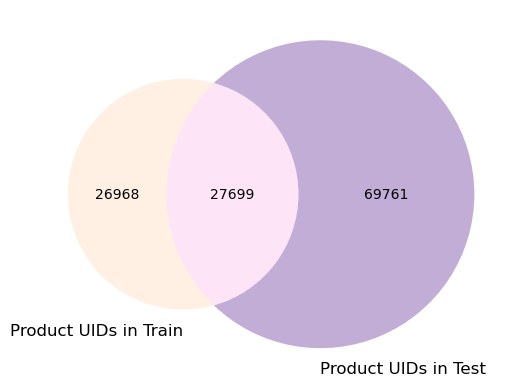

In [344]:
# CODE BLOCK 3: COUNTS FOR DATA ANALYSIS AND PLOT OVERLAP OF PRODUCT_UID

# Count products (via product uid) in train set VS in test set
uid_counts_in_train = df_train["product_uid"].value_counts()
uid_counts_in_test = df_test["product_uid"].value_counts()

# Count product (via product uid) - search term pairs in train set VS in test set
uid_search_pairs_in_train = df_train[["product_uid", "search_term"]].value_counts()
uid_search_pairs_in_test = df_test[["product_uid", "search_term"]].value_counts()

# Plot venn diagram of the top-occuring product-uid's in train VS test sets
venn2([set(df_train["product_uid"]), set(df_test["product_uid"])], set_labels = ("Product UIDs in Train", "Product UIDs in Test"), set_colors = ("peachpuff", "rebeccapurple"))


In [345]:
# CODE BLOCK 4: EXTRACT MOST COMMON ATTRIBUTES

attributes = df_attr.astype({"name":str})
grouped_attr = attributes.groupby(["product_uid", "name"], group_keys=False).agg(lambda x: x)
grouped_attr = grouped_attr.reset_index()
grouped_attr.columns = ["product_uid", "attr_name", "attr_value"]

types_of_attributes = grouped_attr["attr_name"].value_counts()
types_of_attributes = types_of_attributes.to_frame()
types_of_attributes = types_of_attributes.reset_index()
bullets = types_of_attributes["attr_name"].str.contains("Bullet")
types_of_attributes = types_of_attributes[~bullets]

most_used_attributes = types_of_attributes.iloc[0:20]
most_used_attribute_list = []

for i in most_used_attributes["attr_name"]:
    most_used_attribute_list.append(i)
print(most_used_attribute_list)

grouped_attr = grouped_attr[grouped_attr["attr_name"].isin(most_used_attribute_list)]
attributes_as_cols = grouped_attr.pivot(index = "product_uid", columns="attr_name", values="attr_value")

# This query is to answer the question in the data section regarding the most common brands
most_used_brands = grouped_attr[grouped_attr["attr_name"] == "MFG Brand Name"].groupby(["attr_value"]).count()
types_of_attributes.head(20)

['MFG Brand Name', 'Product Width (in.)', 'Product Height (in.)', 'Product Depth (in.)', 'Product Weight (lb.)', 'Color Family', 'Material', 'Color/Finish', 'Certifications and Listings', 'Assembled Height (in.)', 'Assembled Width (in.)', 'Assembled Depth (in.)', 'Product Length (in.)', 'Indoor/Outdoor', 'Commercial / Residential', 'ENERGY STAR Certified', 'Hardware Included', 'Package Quantity', 'Flooring Product Type', 'Color']


attr_name  count
0                MFG Brand Name  86250
5           Product Width (in.)  61137
7          Product Height (in.)  54698
8           Product Depth (in.)  53652
9          Product Weight (lb.)  45175
11                 Color Family  40733
13                     Material  30682
14                 Color/Finish  28564
16  Certifications and Listings  24583
18       Assembled Height (in.)  18299
19        Assembled Width (in.)  18263
20        Assembled Depth (in.)  18198
21         Product Length (in.)  16705
23               Indoor/Outdoor  12938
25     Commercial / Residential   9530
27        ENERGY STAR Certified   8420
28            Hardware Included   7462
29             Package Quantity   6904
31        Flooring Product Type   6243
32                        Color   6222

In [346]:
# CODE BLOCK 5: DESCRIPTIVE STATISTICS
mean = df_train['relevance'].mean()
median = df_train['relevance'].median()
standard_deviation = df_train['relevance'].std()

print("mean: ", mean, "median: ", median, "standard deviation: ", standard_deviation)

mean:  2.3816337910270433 median:  2.33 standard deviation:  0.5339839484172094


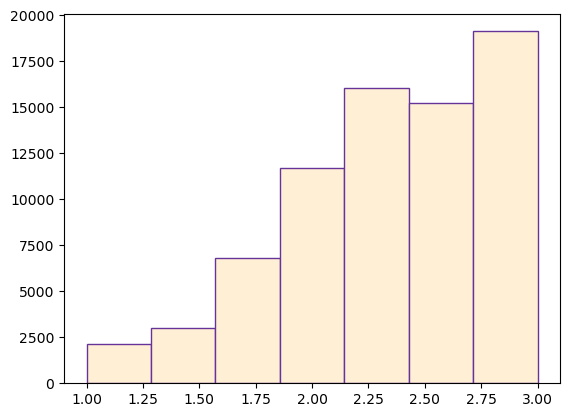

In [347]:
# CODE BLOCK 6: DISTRIBUTION PLOT
distribution_plot = plt.hist(df_train["relevance"], bins = 7, color = "papayawhip", edgecolor = "rebeccapurple", orientation="vertical")

PART 2: PRE-PROCESSING

In [348]:
# CODE BLOCK 7: STEMMING, LEMMATIZING, REMOVING STOPWORDS

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def str_stemmer(s):
	if type(s) == str:
		return " ".join([stemmer.stem(word) for word in s.lower().split()])
	else:
		return


# Changed this function to handle NaN values
def str_common_word(str1, str2):
	if type(str1) == str and type(str2) == str:
		return sum(int(str2.find(word)>=0) for word in str1.split())
	else:
		return


def lemmatize(s):
	if type(s) == str:
		return " ".join([lemmatizer.lemmatize(word) for word in s.lower().split()])
	else:
		return

def lower_and_remove_stopwords(s):
	if type(s) == str:
		return " ".join(word.lower() for word in s.split() if word not in stop_words)
	else:
		return
	
def remove_brackets(s):
	if (type(s) == str):
		new_str = re.sub("\(.+\)", "", s)
		return new_str
	else:
		return

	
# STEMMING ATTRIBUTES
df_all['search_term_stem'] = df_all['search_term'].map(lambda x:str_stemmer(x))
df_all['product_title_stem'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description_stem'] = df_all['product_description'].map(lambda x:str_stemmer(x))

# REMOVE WORDS IN BRACKETS FROM THE TITLES AND DESCRIPTIONS
df_all['product_title_no_brackets'] = df_all['product_title'].map(lambda x:remove_brackets(x))
df_all['product_description_no_brackets'] = df_all['product_description'].map(lambda x:remove_brackets(x))

# REMOVING STOPWORDS AND MAKING WORDS LOWER
df_all['search_term_lower'] = df_all['search_term'].map(lambda x:lower_and_remove_stopwords(x))
df_all['product_title_lower'] = df_all['product_title_no_brackets'].map(lambda x:lower_and_remove_stopwords(x))
df_all['product_description_lower'] = df_all['product_description_no_brackets'].map(lambda x:lower_and_remove_stopwords(x))

# LEMMATIZING ATTRIBUTES
df_all['search_term_lemma'] = df_all['search_term_lower'].map(lambda x: lemmatize(x))
df_all['product_title_lemma'] = df_all['product_title_lower'].map(lambda x:lemmatize(x))
df_all['product_description_lemma'] = df_all['product_description_lower'].map(lambda x:lemmatize(x))



In [565]:
# CODE BLOCK 8: COMPUTE COUNT FEATURES (BASELINE METHOD)

# CALCULATE THE LENGTH OF THE SEARCH QUERY
df_all['len_of_query'] = df_all['search_term_stem'].map(lambda x:len(x.split())).astype(np.int64)

# COMBINE ALL STEMMED ATTRIBUTES INTO ONE COLUMN
df_all['product_info_stemmed'] = df_all['search_term_stem']+"\t"+df_all['product_title_stem']+"\t"+df_all['product_description_stem']

# COMBINE ALL LEMMATISED ATTRIBUTES INTO ONE COLUMN
df_all['product_info_lemmatised'] = df_all['search_term_lemma']+"\t"+df_all['product_title_lemma']+"\t"+df_all['product_description_lemma']

# COMBINE ALL UNSTEMMED ATTRIBUTES INTO ONE COLUMN
df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

# COUNT THE COMMON WORDS BETWEEN THE SEARCH TERM AND EACH ATTRIBUTE (STEMMED)
df_all['word_in_title_stemmed'] = df_all['product_info_stemmed'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]) if type(x) == str else 0)
df_all['word_in_description_stemmed'] = df_all['product_info_stemmed'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]) if type(x) == str else 0)

# COUNT THE COMMON WORDS BETWEEN THE SEARCH TERM AND EACH ATTRIBUTE (LEMMATISED)
df_all['word_in_title_lemmatised'] = df_all['product_info_lemmatised'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]) if type(x) == str else 0)
df_all['word_in_description_lemmatised'] = df_all['product_info_lemmatised'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]) if type(x) == str else 0)


# COUNT THE COMMON WORDS BETWEEN THE SEARCH TERM AND EACH ATTRIBUTE (UNSTEMMED)
df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]) if type(x) == str else 0)
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]) if type(x) == str else 0)


In [350]:
# CODE BLOCK 9: COMPUTING NEW COUNT FEATURES

## FROM HERE, FEATURE EXTRACTION NOT IN THE YAO JEN CHANG CODE

# ADDING ATTRIBUTES - COUNT OF PRODUCT ATTRIBUTES IN THE SEARCH TERM
df_attr['all_values'] = df_attr.groupby(['product_uid'])['value'].transform(lambda x : ','.join((word_tokenize(stemmer.stem(str(x))))))
all_attributes = df_attr[["product_uid", "all_values"]]
all_attributes = all_attributes.drop_duplicates()
df_all_w_attr = df_all.merge(all_attributes, left_on = 'product_uid', right_on = 'product_uid')
df_all_w_attr['search_term_and_all_attributes'] = df_all_w_attr['search_term']+"\t"+df_all_w_attr['all_values']
df_all_w_attr['word_in_attributes'] = df_all_w_attr['search_term_and_all_attributes'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]) if type(x)==str else 0)




In [352]:
# CODE BLOCK 10: PROCESS MEASUREMENT FEATURES

def cleanup_text_in_df(text, dataframe, column):
    dataframe[column] = dataframe[column].str.replace(text, '')
    return dataframe


columns_to_clean = ["Assembled Height (in.)", "Assembled Width (in.)", "Product Depth (in.)", "Product Height (in.)", "Product Length (in.)", "Product Width (in.)"]
attributes_as_cols = cleanup_text_in_df("in", attributes_as_cols, "Assembled Depth (in.)")
for column in columns_to_clean:
    attributes_as_cols = cleanup_text_in_df("in", attributes_as_cols, column)


def make_one_measurement(depth_col, width_col, length_col, var_type):
    def check_nan(col_name):
        nan = type(float('nan'))
        if type(col_name) != nan:
            return True
    measurements = []
    if check_nan(depth_col):
        depth = depth_col
        measurements.append(depth)
    if check_nan(width_col):
        width = width_col
        measurements.append(width)
    if check_nan(length_col):
        length = length_col
        measurements.append(length)
    if var_type == "str":
        measurement_str = (" x ").join(measurements)
        return measurement_str
    elif var_type == "list":
        return measurements


attributes_as_cols["Assembled Measurement (DxWxH)"] = attributes_as_cols.apply(lambda x: make_one_measurement(x["Assembled Depth (in.)"], x["Assembled Height (in.)"], x["Assembled Width (in.)"], "str"), axis = 1)
attributes_as_cols["Product Measurement (LxWxD)"] = attributes_as_cols.apply(lambda x: make_one_measurement(x["Product Length (in.)"], x["Product Width (in.)"], x["Assembled Depth (in.)"], "str"), axis = 1)
attributes_as_cols["Product Measurement (DxWxH)"] = attributes_as_cols.apply(lambda x: make_one_measurement(x["Product Length (in.)"], x["Product Width (in.)"], x["Assembled Height (in.)"], "str"), axis = 1)

attributes_as_cols["Assembled Measurement (DxWxH) list"] = attributes_as_cols.apply(lambda x: make_one_measurement(x["Assembled Depth (in.)"], x["Assembled Height (in.)"], x["Assembled Width (in.)"], "list"), axis = 1)
attributes_as_cols["Product Measurement (LxWxD) list"] = attributes_as_cols.apply(lambda x: make_one_measurement(x["Product Length (in.)"], x["Product Width (in.)"], x["Assembled Depth (in.)"], "list"), axis = 1)
attributes_as_cols["Product Measurement (DxWxH) list"] = attributes_as_cols.apply(lambda x: make_one_measurement(x["Product Length (in.)"], x["Product Width (in.)"], x["Assembled Height (in.)"], "list"), axis = 1)


In [353]:
# CODE BLOCK 11: DATA EXPLORATION TO DETERMINE HOW COMMON TITLE + MEASUREMENT IS IN THE SEARCH TERMS

def recognise_measurements(dataframe_to_recognise, dataframe_to_modify):
    dataframe_to_modify["measurement_in_search_term"] = ""
    measurements_in_term = {}
    regex_1 = re.compile('\d+x\d+')
    regex_2 = re.compile('\d+\*\d+')
    for i in dataframe_to_recognise.itertuples():
        id = i[1]
        term_1 = regex_1.match(str(i[4]))
        term_2 = regex_2.match(str(i[4]))
        if term_1:
            measurements_in_term[i[2]]=term_1.group(0)
            dataframe_to_modify.at[id, "measurement_in_search_term"] = term_1.group(0)
        if term_2:
            split_term = term_2.group(0).split("*")
            term_2 = split_term[0] + " x " + split_term[1]
            measurements_in_term[i[2]] = term_2
            dataframe_to_modify.at[id, "measurement_in_search_term"] = term_2
    return measurements_in_term


measurements = recognise_measurements(df_all, df_all_w_attr)


# Add list versions of the measurements recognised in the search terms to the large dataframe
df_all_w_attr["measurement_in_search_term_list"] = df_all_w_attr["measurement_in_search_term"][df_all_w_attr["measurement_in_search_term"].str.isalnum()].map(lambda x: [i for i in x.split("x")])
df_all_w_attr["measurement_in_search_term_list"][df_all_w_attr["measurement_in_search_term_list"].notna()]


88          [1, 1]
92          [4, 8]
361         [5, 5]
485         [4, 6]
852         [6, 6]
            ...   
219035    [24, 18]
219036      [6, 8]
219905      [6, 6]
220607    [38, 38]
220828    [34, 18]
Name: measurement_in_search_term_list, Length: 1101, dtype: object

In [785]:
# CODE BLOCK 12: Print out how many times measurements show up in search terms
print(len(list(measurements.values())))
print(list(measurements.values()))

1043
['4x8', '5x5', '4x6', '2 x 3', '4 x 8', '6x6', '4x4', '2x4', '34x34', '1x8', '8x16', '4x8', '4x9', '4x12', '4 x 8', '4x9', '1x6', '2x2', '4x4', '4x8', '24x36', '24x73', '30x68', '30x80', '1x6', '4 x 8', '2x4', '1x6', '4x8', '4x6', '12x12', '2x4', '2x2', '1x8', '64 x 12', '4x4', '34x34', '4x6', '4x4', '2x6', '1x6', '34x76', '4x6', '1x8', '1x12', '6x8', '4x8', '2x8', '12x12', '64 x 12', '10x20', '4 x 8', '49x97', '4x6', '4x4', '8x8', '4x6', '2x8', '4x6', '1x8', '2x3', '49x97', '2x4', '10x10', '6x6', '14 x 32', '6x6', '4x4', '4x6', '2x2', '8x16', '10x10', '1x8', '14 x 32', '64 x 12', '4x8', '8x10', '8x8', '24x36', '12x12', '2x2', '4x8', '4x4', '12x12', '8x16', '3x6', '4x4', '5x5', '64 x 12', '4x6', '4x9', '1x6', '2x4', '2x4', '16x14', '8x4', '1x6', '4x8', '8x6', '7x36', '4x8', '64 x 12', '31x32', '8x8', '2x12', '8x4', '8x16', '1x6', '2x4', '2x2', '1x6', '2x4', '8x6', '30x68', '4x6', '1x6', '2x4', '6x8', '6x10', '80x34', '2x4', '2x4', '3x6', '49x97', '80x30', '33x38', '2x4', '2x2', '2

In [354]:
# CODE BLOCK 13: MAKE PRODUCT TITLE + MEASUREMENTS FEATURE

measurements_in_product = attributes_as_cols[["Assembled Measurement (DxWxH)", "Product Measurement (LxWxD)", "Product Measurement (DxWxH)", "Assembled Measurement (DxWxH) list", "Product Measurement (LxWxD) list", "Product Measurement (DxWxH) list"]]
measurements_in_product.reset_index(inplace = True)
measurements_in_product.columns = ["product_uid", "Assembled Measurement (DxWxH)", "Product Measurement (LxWxD)", "Product Measurement (DxWxH)", "Assembled Measurement (DxWxH) list", "Product Measurement (LxWxD) list", "Product Measurement (DxWxH) list"]
df_all_w_attr = df_all_w_attr.merge(measurements_in_product, left_on = 'product_uid', right_on = 'product_uid')

def assemble_composite_feature(output_col, input_col_1, input_col_2):
    df_all_w_attr[output_col] = df_all_w_attr[input_col_1] + " " + df_all_w_attr[input_col_2]

# Unstemmed
assemble_composite_feature("title_and_assembled_measurement", "product_title", "Assembled Measurement (DxWxH)")
assemble_composite_feature("title_and_measurement_LWD", "product_title", "Product Measurement (LxWxD)")
assemble_composite_feature("title_and_measurement_DWH", "product_title", "Product Measurement (DxWxH)")

# Stemmed
assemble_composite_feature("title_and_assembled_measurement_stem", "product_title_stem", "Assembled Measurement (DxWxH)")
assemble_composite_feature("title_and_measurement_LWD_stem", "product_title_stem", "Product Measurement (LxWxD)")
assemble_composite_feature("title_and_measurement_DWH_stem", "product_title_stem", "Product Measurement (DxWxH)")

# Lemmatized (and other pre-processing)
assemble_composite_feature("title_and_assembled_measurement_lemma", "product_title_lemma", "Assembled Measurement (DxWxH)")
assemble_composite_feature("title_and_measurement_LWD_lemma", "product_title_lemma", "Product Measurement (LxWxD)")
assemble_composite_feature("title_and_measurement_DWH_lemma", "product_title_lemma", "Product Measurement (DxWxH)")







In [355]:
# CODE BLOCK 14: MAKE PRODUCT TITLE + COLOUR FEATURE
colours = attributes_as_cols[["Color Family", "Color/Finish"]]
colours = colours.reset_index()

# Make Colour Stems
colours['Color Family Stem'] = colours['Color Family'].map(lambda x:str_stemmer(x))
colours['Color/Finish Stem'] = colours['Color/Finish'].map(lambda x:str_stemmer(x))

# Lemmatize colours
colours['color_family_lower'] = colours['Color Family'].map(lambda x:lower_and_remove_stopwords(x))
colours['color_lower'] = colours['Color/Finish'].map(lambda x:lower_and_remove_stopwords(x))

colours['color_family_lemma'] = colours['color_family_lower'].map(lambda x: lemmatize(x))
colours['color_lemma'] = colours['color_lower'].map(lambda x: lemmatize(x))


df_all_w_attr = df_all_w_attr.merge(colours, how = "left", on = "product_uid")

# Non-stemmed
assemble_composite_feature("title_and_color","product_title","Color/Finish")
assemble_composite_feature("title_and_color_fam", "product_title", "Color Family")

# Stemmed
assemble_composite_feature("title_and_color_stem", "product_title_stem", "Color/Finish Stem")
assemble_composite_feature("title_and_color_fam_stem", "product_title_stem", "Color Family Stem")

# Lemmatized (and other pre-processing)
assemble_composite_feature("title_and_color_lemma", "product_title_lemma", "color_lemma")
assemble_composite_feature("title_and_color_fam_lemma", "product_title_lemma", "color_family_lemma")



In [356]:
# CODE BLOCK 15: MAKE PRODUCT TITLE + MFG BRAND NAME FEATURE
brands = attributes_as_cols["MFG Brand Name"]
brands = brands.reset_index()
brands["brand_lower"] = brands["MFG Brand Name"].map(lambda x:lower_and_remove_stopwords(x))
brands["brand_lemma"] = brands["brand_lower"].map(lambda x: lemmatize(x))

df_all_w_attr = df_all_w_attr.merge(brands, how = 'left', on = 'product_uid')

assemble_composite_feature("title_and_brand_lemma", "product_title_lemma", "brand_lemma")
assemble_composite_feature("title_and_brand", "product_title", "brand_lower")

In [365]:
# CODE BLOCK 16: MAKE PRODUCT TITLE + MATERIAL
material = attributes_as_cols["Material"]
material = material.reset_index()
material["material_lower"] = material["Material"].map(lambda x: lower_and_remove_stopwords(x))
material["material_lemma"] = material["material_lower"].map(lambda x: lemmatize(x))

df_all_w_attr = df_all_w_attr.merge(material, how = 'left', on = 'product_uid')

assemble_composite_feature("title_and_material_lemma", "product_title_lemma", "material_lemma")


In [357]:
# CODE BLOCK 17: MAKE PRODUCT-TYPE ATTRIBUTE VIA PRODUCT TITLE (Remove terms that are not likely to show up in a search term to achieve a better matching between the two)

# Step 1: Prepare search terms and product_titles with leading and ending spaces
df_all_w_attr["product_title_lemma"] = " " + df_all_w_attr["product_title_lemma"].astype(str)
df_all_w_attr["search_term_lemma"] = " " + df_all_w_attr["search_term_lemma"].astype(str)


# Step 2: Prepare Brand Dictionaries
brand_lemmas = brands[["MFG Brand Name", "brand_lemma"]].groupby(["brand_lemma"]).count()
brand_lemmas = brand_lemmas.reset_index()
brand_lemmas = brand_lemmas["brand_lemma"]
brand_list = brand_lemmas.tolist()
brand_list.remove("wood") # for some reason, one of the included brands is simply "wood", which affects the removal of other brands so remove it
brand_list = [" " + i + " " for i in brand_list]
brand_list.append(" briggs stratton ") # encountered this in search term
brand_list.append(" briggs &amp; stratton ")
brand_list.append("calais")
brand_list.append("vero")


# Step 3: Prepare Colour Dictionaries
colour_family_lemmas = colours[["color_family_lemma", "product_uid"]].groupby("color_family_lemma").count()
colour_family_lemmas = colour_family_lemmas.reset_index()
colour_list = colour_family_lemmas["color_family_lemma"].tolist()
colour_lemmas = colours[["color_lemma", "product_uid"]].groupby("color_lemma").count()
colour_lemmas = colour_lemmas.reset_index()
for i in colour_lemmas["color_lemma"].tolist():
    colour_list.append(i)
colour_list = [" " + i + " " for i in colour_list]
colour_list.append(", silver")


# Step 4: Prepare Material Dictionaries
material_lemmas = material[["material_lemma", "product_uid"]].groupby("material_lemma").count()
material_lemmas = material_lemmas.reset_index()
material_list = material_lemmas["material_lemma"].tolist()
material_list = [" " + i + " " for i in material_list]
# material_list.remove("*")



# Step 5: Match and remove brands
def matching_brands(dataframe_to_modify):
    # Prepare empty dictionaries to append into
    clean_product_title = dict()
    skipped_product_title = dict()
    clean_search_term = dict()
    brands_in_search_term = dict()
    skipped_search_term = dict()

    # Iterate through all rows as tuples
    for i in dataframe_to_modify.itertuples():
        # BRANDS
        # Find and remove brand in product_title
        for brand in brand_list:
            if i[16].find(brand) != -1:
                new_title = i[16].replace(brand, " ")
                clean_product_title[i[1]] = new_title
            else:
                skipped_product_title[i[1]] = i[16]
            # Find and remove brand in search_term
            if i[15].find(brand) != -1:
                new_search_term = i[15].replace(brand, " ")
                clean_search_term[i[1]] = new_search_term
                # Add brand in search term to dictionary
                brands_in_search_term[i[1]] = brand
            else:
                skipped_search_term[i[1]] = i[15]
    return clean_product_title, clean_search_term, brands_in_search_term, skipped_product_title


clean_product_titles, clean_search_terms, brands_in_search_term, skipped_product_title = matching_brands(df_all_w_attr)

# Step 6: Match and remove colours and materials

# Prepare Empty Dictionaries for Other Attributes
colours_in_search_term = dict()
material_in_search_term = dict()

def matching_attribute(attribute_list, product_title_dict, search_term_dict, attribute_dict):
    for attribute in attribute_list:
        for key, value in product_title_dict.items():
            if value.find(attribute) != -1:
                new_title = value.replace(attribute, " ")
                product_title_dict[key] = new_title
        for key, value in search_term_dict.items():
            if value.find(attribute) != -1:
                new_search_term = value.replace(attribute, " ")
                search_term_dict[key] = new_search_term
                attribute_dict[key] = attribute 

            
matching_attribute(colour_list, clean_product_titles, clean_search_terms, colours_in_search_term)
matching_attribute(material_list, clean_product_titles, clean_search_terms, material_in_search_term)


'''
'\d+(\.\d+)?\s*in\.\s*x\s*\d+(\.\d+)?\s*in\.', '\d+(\.\d+)?\s*in\.\s*w\s*x\s*\d+(\.\d+)?\s*in\.\s*h\s*x\s*\d+(\.\d+)?\s*in\.\s*d', '\d+/\d+\s*in\.\s*x\s*\d+(\.\d+)?\s*in\.\s*x\s*\d+\s*ft\.',
'''


# Step 7: Match and Remove Measurements
measurements_in_search_term = dict()
def matching_measurements(product_title_dict, search_term_dict, attribute_dict):
    regex_commands = ['\S+-\S+', '\d+x\d+', '\d+\*\d+', '\b\w+-\w+\b','\d+-\S+',
                      '\d+ \S+ x \d+ +\S+ x \d+ \S+','.+\S+ ft.', '.+\S+ in\.']
    for command in regex_commands:
        for key, value in product_title_dict.items():
            match = []
            re_term = re.compile(command)
            matched_term = re.search(re_term, value)
            if matched_term:
                matched_measurement = matched_term.group(0)
                new_value = value.replace(matched_measurement, " ")
                product_title_dict[key] = new_value
    return product_title_dict, search_term_dict, attribute_dict
  
        
clean_product_titles, clean_search_terms, measurements_in_search_term = matching_measurements(clean_product_titles, clean_search_terms, measurements_in_search_term)
        
# Step 8: Remove digits from the terms   
def remove_digits(value):
    if type(value) == str:
        value_list = value.split()
        new_values = [term for term in value_list if not term.isnumeric() and term.isalpha()]
        new_str = " ".join(new_values)
        return new_str
    else:
        return " "


skipped_product_title.update(clean_product_titles)


from textblob import TextBlob

# Step 9: Extract nouns from product_titles (Idea sourced by similar approach described by Team Quartet: https://web.archive.org/web/20190914022539/http://blog.kaggle.com/2015/07/22/crowdflower-winners-interview-3rd-place-team-quartet/)

product_title_nouns_only = dict()

for key, value in skipped_product_title.items():
    if type(value) == str:
        text_blob = TextBlob(value)
        tags = text_blob.tags
        only_nouns = []
        for term in tags:
            if term[1] == "NN" or term[1] == "VB" or term[1] == "JJ":
                only_nouns.append(term[0])
        product_title_nouns_only[key] = " ".join(only_nouns)


# # Step 10: Add all extracted attributes to the large dataframe
df_all_w_attr["clean_product_title"] = df_all_w_attr["id"].map(product_title_nouns_only)
df_all_w_attr["clean_search_term"] = df_all_w_attr["id"].map(clean_search_terms)
df_all_w_attr["color_in_search_term"] = df_all_w_attr["id"].map(colours_in_search_term)
df_all_w_attr["material_in_search_term"] = df_all_w_attr["id"].map(material_in_search_term)
df_all_w_attr["brand_in_search_term"] = df_all_w_attr["id"].map(brands_in_search_term)

df_all_w_attr['clean_product_title'] = df_all_w_attr['clean_product_title'].map(lambda x:remove_digits(x))
df_all_w_attr['clean_search_term'] = df_all_w_attr['clean_search_term'].map(lambda x:remove_digits(x))




FEATURE EXTRACTION

In [359]:
# # CODE BLOCK 18: SPACY -- OVERLAP BETWEEN THESE FEATURES AND COSINE SIMILARITY -- SKIP (SEE REPORT FOR WHY)
# nlp = en_core_web_lg.load()

# def spacy_similarity(doc_1_col, doc_2_col):
#     doc_1 = nlp(doc_1_col)
#     doc_2 = nlp(doc_2_col)
#     return doc_1.similarity(doc_2)


# # Spacy similarity score between just title and search term
# df_all_w_attr["title_spacy_similarity"] = df_all_w_attr.apply(lambda x: spacy_similarity(x["product_title"], x["search_term"]), axis = 1)
# df_all_w_attr

/var/folders/wr/c8zkd12d081692wcbdb3w10c0000gn/T/ipykernel_2465/3540128464.py:7: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc_1.similarity(doc_2)


id  product_uid  \
0           2.0     100001.0   
1           3.0     100001.0   
2           9.0     100002.0   
3          16.0     100005.0   
4          17.0     100005.0   
...         ...          ...   
56540  221457.0     206638.0   
56541  221458.0     206639.0   
56542  221463.0     206641.0   
56543  221471.0     206648.0   
56544  221473.0     206650.0   

                                                                                                  product_title  \
0                                                                             Simpson Strong-Tie 12-Gauge Angle   
1                                                                             Simpson Strong-Tie 12-Gauge Angle   
2                               BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating   
3                                Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included)   
4                                Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included)   
...                                                                                                         ...   
56540             Atlantic Windowpane 576 CD or 192 DVD Blu-Ray or Games Maple Sliding Glass Door Media Cabinet   
56541                                                    Philips 40-Watt Halogen R20 Flood Light Bulb (12-Pack)   
56542                               Schlage Camelot In-Active Aged Bronze Handleset with Left-Hand Accent Lever   
56543                                                      Plastec 11 in. x 24 in. Rose Garden Wall Decor Steel   
56544  LICHTENBERG Pool Blue No. 918 Millennial Ryan Heathered Texture Sheer Curtain Panel, 40 in. W x 63 in. L   

                                   search_term  relevance  \
0                                angle bracket       3.00   
1                                    l bracket       2.50   
2                                    deck over       3.00   
3                             rain shower head       2.33   
4                           shower only faucet       2.67   
...                                        ...        ...   
56540                           tv riser glass       1.00   
56541                        r20 halogen light       3.00   
56542  schlage lock siena half dummy knob with       2.33   
56543                        zen garden  decor       3.00   
56544             fine sheer curtain 63 inches       2.33   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  product_description  \
0                                                                                                                                                                                                                                                                     Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of a

In [367]:
# CODE BLOCK 19: Function which calculates pairwise distance measures between the entries of two columns of a dataframe

def apply_feature_score(newcolname, col1, col2, feature_scorer):
    df_all_w_attr[newcolname] = df_all_w_attr.apply(lambda x: feature_scorer(str(x[col1]), str(x[col2])), axis = 1)


Section: Spacy Similarity

In [ ]:
# ## CODE BLOCK 20: DISTANCE MEASURES WITH SPACY ## -- DON'T RUN FOR FINAL ASSIGNMENT

# # Spacy Similarity -- Unstemmed; used only for comparison
# apply_feature_score("spacy_title_and_assembled_measurement", "title_and_assembled_measurement", "search_term", spacy_similarity)
# apply_feature_score("spacy_title_and_measurement_LWD","title_and_measurement_LWD", "search_term", spacy_similarity)
# apply_feature_score("spacy_title_and_measurement_DWH","title_and_measurement_DWH", "search_term", spacy_similarity)
# apply_feature_score("spacy_title_and_color","title_and_color", "search_term", spacy_similarity)
# apply_feature_score("spacy_title_and_color_fam","title_and_color_fam", "search_term", spacy_similarity)

# # Spacy Similarity -- Stemmed
# apply_feature_score("spacy_description_stemmed","product_description_stem", "search_term_stem", spacy_similarity)
# apply_feature_score("spacy_title_stem_and_assembled_measurement", "title_and_assembled_measurement_stem", "search_term_stem", spacy_similarity)
# apply_feature_score("spacy_title_and_measurement_LWD_stem", "title_and_measurement_LWD_stem", "search_term_stem", spacy_similarity)
# apply_feature_score("spacy_title_and_measurement_DWH_stem", "title_and_measurement_DWH_stem", "search_term_stem", spacy_similarity)
# apply_feature_score("spacy_title_and_color_stem","title_and_color_stem", "search_term_stem", spacy_similarity)
# apply_feature_score("spacy_title_and_color_fam_stem","title_and_color_fam_stem", "search_term_stem", spacy_similarity)


Section: Other Similarity Scores via TF-IDF

In [368]:
# CODE BLOCK 21: VECTOR SIMILARITY INDICES VIA TF-IDF (COSINE, EUCLIDEAN) -- FUNCTION DEFINITIONS

small_sample = df_all_w_attr.loc[:10].copy()
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import pairwise_distances 
from sklearn.metrics import DistanceMetric

# Vectorise the text 
tf_idf_vectoriser = TfidfVectorizer()
tf_idf_bigrams = TfidfVectorizer(ngram_range=(1,2))
tf_idf_trigrams = TfidfVectorizer(ngram_range=(1,3))

# Define function which calculates distance measures pairwise
def create_pairwise_distance_fn(distance_measure, vectoriser):
    def pairwise_distance(text_1, text_2):
        try:
            if len(text_1) > 0 and len(text_2) > 0 and text_1 != 'nan' and text_2 != 'nan' and text_1 != "0" and text_2 != "0":
                texts = [text_1, text_2]
                scores = vectoriser.fit_transform(texts)
                result = distance_measure(scores[0], scores[1])
                return result[0][0]
        except ValueError:
            return None
    return pairwise_distance

# def apply_distance_score(df, newcolname, col1, col2, feature_scorer):
#     df[newcolname] = df.apply(lambda x: feature_scorer(str(x[col1]), str(x[col2])), axis = 1)


In [369]:
# CODE BLOCK 22: APPLY COSINE SIMILARITY (WORDS)
apply_feature_score("cosine_product_title_lemma", "product_title_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_product_description_lemma", "product_description_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_title_and_assembled_measurement_lemma", "title_and_assembled_measurement_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_title_and_measurement_LWD_lemma", "title_and_measurement_LWD_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_title_and_measurement_DWH_lemma", "title_and_measurement_DWH_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_title_and_color_fam_lemma", "title_and_color_fam_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_title_and_color_lemma", "title_and_color_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_title_and_brand_lemma", "title_and_brand_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_title_and_material_lemma", "title_and_material_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_cleaned_title", "clean_product_title", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_color_matching", "color_lemma", "color_in_search_term", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_material_matching", "material_lemma", "material_in_search_term", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_brand_matching", "brand_lemma", "brand_in_search_term", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_assembled_measurement_matched", "Assembled Measurement (DxWxH)", "measurement_in_search_term", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_measurement_LWD_matched", "Product Measurement (LxWxD)", "measurement_in_search_term", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))
apply_feature_score("cosine_measurement_DWH_matched", "Product Measurement (DxWxH)", "measurement_in_search_term", create_pairwise_distance_fn(cosine_similarity, tf_idf_vectoriser))



In [ ]:
# CODE BLOCK 23: Demonstration of brand matching with cosine similarity (scale 0 to 1)
df_all_w_attr[["brand_lemma", "brand_in_search_term", "cosine_brand_matching"]][df_all_w_attr["cosine_brand_matching"].notna()]

brand_lemma brand_in_search_term  cosine_brand_matching
11             toro     briggs stratton                     0.0
13             toro               honda                     0.0
14      hampton bay         hampton bay                     1.0
30          samsung             samsung                     1.0
45        unbranded               shelf                     0.0
...             ...                  ...                    ...
134146       dewalt              impact                     0.0
134154       philip                watt                     0.0
134163       dewalt              impact                     0.0
134176       minwax              minwax                     1.0
134180      generac             generac                     1.0

[22671 rows x 3 columns]

In [370]:
# CODE BLOCK 24: APPLY EUCLIDEAN DISTANCE (WORDS)
apply_feature_score("euclidean_product_title_lemma", "product_title_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_product_description_lemma", "product_description_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_title_and_assembled_measurement_lemma", "title_and_assembled_measurement_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_title_and_measurement_LWD_lemma", "title_and_measurement_LWD_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_title_and_measurement_DWH_lemma", "title_and_measurement_DWH_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_title_and_color_fam_lemma", "title_and_color_fam_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_title_and_color_lemma", "title_and_color_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_title_and_brand_lemma", "title_and_brand_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_title_and_material_lemma", "title_and_material_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_cleaned_title", "clean_product_title", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_color_matching", "color_lemma", "color_in_search_term", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_material_matching", "material_lemma", "material_in_search_term", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_brand_matching", "brand_lemma", "brand_in_search_term", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_assembled_measurement_matched", "Assembled Measurement (DxWxH)", "measurement_in_search_term", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_measurement_LWD_matched", "Product Measurement (LxWxD)", "measurement_in_search_term", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))
apply_feature_score("euclidean_measurement_DWH_matched", "Product Measurement (DxWxH)", "measurement_in_search_term", create_pairwise_distance_fn(euclidean_distances, tf_idf_vectoriser))



In [378]:
# CODE BLOCK 25: APPLY SPACY DISTANCE TO ALL LEMMATISED ATTRIBUTES (INCLUDING NEW ONES) 
'''
NOTE 1 : though spacy technically has pre-processing steps baked into the pipeline, 
I chose to stil run it on the lemmatised pre-processed columns for consistency
NOTE 2: This cell takes approximately 
'''

apply_feature_score("spacy_product_title_lemma","product_title_lemma", "search_term_lemma", spacy_similarity)
apply_feature_score("spacy_product_description_lemma","product_description_lemma", "search_term_lemma", spacy_similarity)
apply_feature_score("spacy_title_and_assembled_measurement_lemma","title_and_assembled_measurement_lemma", "search_term_lemma", spacy_similarity)
apply_feature_score("spacy_title_and_measurement_LWD_lemma","title_and_measurement_LWD_lemma", "search_term_lemma", spacy_similarity)
apply_feature_score("spacy_title_and_measurement_DWH_lemma","title_and_measurement_DWH_lemma", "search_term_lemma", spacy_similarity)
apply_feature_score("spacy_title_and_color_fam_lemma","title_and_color_fam_lemma", "search_term_lemma", spacy_similarity)
apply_feature_score("spacy_title_and_color_lemma","title_and_color_lemma", "search_term_lemma", spacy_similarity)
apply_feature_score("spacy_title_and_brand_lemma","title_and_brand_lemma", "search_term_lemma", spacy_similarity)
apply_feature_score("spacy_title_and_material_lemma","title_and_material_lemma", "search_term_lemma", spacy_similarity)
apply_feature_score("spacy_cleaned_title","clean_product_title", "search_term_lemma", spacy_similarity)
apply_feature_score("spacy_color_matching","color_lemma", "color_in_search_term", spacy_similarity)
apply_feature_score("spacy_material_matching","material_lemma", "material_in_search_term", spacy_similarity)
apply_feature_score("spacy_brand_matching","brand_lemma", "material_in_search_term", spacy_similarity)
apply_feature_score("spacy_assembled_measurement_matching","Assembled Measurement (DxWxH)", "measurement_in_search_term", spacy_similarity)
apply_feature_score("spacy_DWH_measurement_matching","Product Measurement (DxWxH)", "measurement_in_search_term", spacy_similarity)
apply_feature_score("spacy_LWD_measurement_matching","Product Measurement (LxWxD)", "measurement_in_search_term", spacy_similarity)

/var/folders/wr/c8zkd12d081692wcbdb3w10c0000gn/T/ipykernel_2465/3540128464.py:7: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc_1.similarity(doc_2)


/var/folders/wr/c8zkd12d081692wcbdb3w10c0000gn/T/ipykernel_2465/646171035.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_w_attr[newcolname] = df_all_w_attr.apply(lambda x: feature_scorer(str(x[col1]), str(x[col2])), axis = 1)
/var/folders/wr/c8zkd12d081692wcbdb3w10c0000gn/T/ipykernel_2465/3540128464.py:7: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc_1.similarity(doc_2)
/var/folders/wr/c8zkd12d081692wcbdb3w10c0000gn/T/ipykernel_2465/646171035.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fr

In [371]:
# CODE BLOCK 26: SIMILARITY SCORE VIA CHARACTER COUNTS (JACCARD INDEX) -- THE PROPORTION OF SHARED CHARACTERS
def jaccard_distance(text_1, text_2):
    set_1 = set(text_1)
    set_2 = set(text_2)
    set_union = set_1.union(set_2)
    set_intersection = set_1.intersection(set_2)
    if len(set_union) != 0:
        score = len(set_intersection)/len(set_union)
        return score
    else:
        return None


apply_feature_score("jaccard_product_title_lemma","product_title_lemma", "search_term_lemma", jaccard_distance)
apply_feature_score("jaccard_product_description_lemma","product_description_lemma", "search_term_lemma", jaccard_distance)
apply_feature_score("jaccard_title_and_assembled_measurement_lemma","title_and_assembled_measurement_lemma", "search_term_lemma", jaccard_distance)
apply_feature_score("jaccard_title_and_measurement_LWD_lemma","title_and_measurement_LWD_lemma", "search_term_lemma", jaccard_distance)
apply_feature_score("jaccard_title_and_measurement_DWH_lemma","title_and_measurement_DWH_lemma", "search_term_lemma", jaccard_distance)
apply_feature_score("jaccard_title_and_color_fam_lemma","title_and_color_fam_lemma", "search_term_lemma", jaccard_distance)
apply_feature_score("jaccard_title_and_color_lemma","title_and_color_lemma", "search_term_lemma", jaccard_distance)
apply_feature_score("jaccard_title_and_brand_lemma","title_and_brand_lemma", "search_term_lemma", jaccard_distance)
apply_feature_score("jaccard_title_and_material_lemma","title_and_material_lemma", "search_term_lemma", jaccard_distance)
apply_feature_score("jaccard_cleaned_title","clean_product_title", "search_term_lemma", jaccard_distance)
apply_feature_score("jaccard_color_matching","color_lemma", "color_in_search_term", jaccard_distance)
apply_feature_score("jaccard_material_matching","material_lemma", "material_in_search_term", jaccard_distance)
apply_feature_score("jaccard_brand_matching","brand_lemma", "brand_in_search_term", jaccard_distance)
apply_feature_score("jaccard_assembled_measurement_matched", "Assembled Measurement (DxWxH)", "measurement_in_search_term", jaccard_distance)
apply_feature_score("jaccard_measurement_LWD_matched", "Product Measurement (LxWxD)", "measurement_in_search_term", jaccard_distance)
apply_feature_score("jaccard_measurement_DWH_matched", "Product Measurement (DxWxH)", "measurement_in_search_term", jaccard_distance)


In [372]:
# CODE BLOCK 27: SIMILARITY SCORE VIA WORD COUNTS (JACCARD INDEX) -- THE PROPORTION OF SHARED WORDS
def jaccard_word_distance(text_1, text_2):
    list_1 = text_1.split(" ")
    list_2 = text_2.split(" ")
    set_1 = set(list_1)
    set_2 = set(list_2)
    set_union = set_1.union(set_2)
    set_intersection = set_1.intersection(set_2)
    if len(set_union) != 0:
        score = len(set_intersection)/len(set_union)
        return score
    else:
        return None



apply_feature_score("jaccard_word_product_title_lemma","product_title_lemma", "search_term_stem", jaccard_word_distance)
apply_feature_score("jaccard_word_product_description_lemma","product_description_lemma", "search_term_stem", jaccard_word_distance)
apply_feature_score("jaccard_word_title_and_assembled_measurement_lemma","title_and_assembled_measurement_lemma", "search_term_stem", jaccard_word_distance)
apply_feature_score("jaccard_word_title_and_measurement_LWD_lemma","title_and_measurement_LWD_lemma", "search_term_stem", jaccard_word_distance)
apply_feature_score("jaccard_word_title_and_measurement_DWH_lemma","title_and_measurement_DWH_lemma", "search_term_stem", jaccard_word_distance)
apply_feature_score("jaccard_word_title_and_color_fam_lemma","title_and_color_fam_lemma", "search_term_stem", jaccard_word_distance)
apply_feature_score("jaccard_word_title_and_color_lemma","title_and_color_lemma", "search_term_stem", jaccard_word_distance)
apply_feature_score("jaccard_word_title_and_brand_lemma","title_and_brand_lemma", "search_term_stem", jaccard_word_distance)
apply_feature_score("jaccard_word_title_and_material_lemma","title_and_material_lemma", "search_term_stem", jaccard_word_distance)
apply_feature_score("jaccard_word_cleaned_title","clean_product_title", "search_term_lemma", jaccard_word_distance)
apply_feature_score("jaccard_word_color_matching","color_lemma", "color_in_search_term", jaccard_word_distance)
apply_feature_score("jaccard_word_material_matching","material_lemma", "material_in_search_term", jaccard_word_distance)
apply_feature_score("jaccard_word_brand_matching","brand_lemma", "brand_in_search_term", jaccard_word_distance)
apply_feature_score("jaccard_word_assembled_measurement_matched", "Assembled Measurement (DxWxH)", "measurement_in_search_term", jaccard_word_distance)
apply_feature_score("jaccard_word_measurement_LWD_matched", "Product Measurement (LxWxD)", "measurement_in_search_term", jaccard_word_distance)
apply_feature_score("jaccard_word_measurement_DWH_matched", "Product Measurement (DxWxH)", "measurement_in_search_term", jaccard_word_distance)


In [373]:
# CODE BLOCK 28: APPLY COSINE DISTANCE (UNI & BIGRAMS)
apply_feature_score("cosine_product_title_lemma_bigrams", "product_title_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_bigrams))
apply_feature_score("cosine_product_description_lemma_bigrams", "product_description_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_bigrams))
apply_feature_score("cosine_title_and_assembled_measurement_lemma_bigrams", "title_and_assembled_measurement_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_bigrams))
apply_feature_score("cosine_title_and_measurement_LWD_lemma_bigrams", "title_and_measurement_LWD_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_bigrams))
apply_feature_score("cosine_title_and_measurement_DWH_lemma_bigrams", "title_and_measurement_DWH_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_bigrams))
apply_feature_score("cosine_title_and_color_fam_lemma_bigrams", "title_and_color_fam_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_bigrams))
apply_feature_score("cosine_title_and_color_lemma_bigrams", "title_and_color_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_bigrams))
apply_feature_score("cosine_title_and_brand_lemma_bigrams", "title_and_brand_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_bigrams))
apply_feature_score("cosine_title_and_material_lemma_bigrams", "title_and_material_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_bigrams))


In [374]:
# CODE BLOCK 29: APPLY COSINE DISTANCE (UNI, BI, AND TRIGRAMS)
apply_feature_score("cosine_product_title_lemma_trigrams", "product_title_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_trigrams))
apply_feature_score("cosine_product_description_lemma_trigrams", "product_description_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_trigrams))
apply_feature_score("cosine_title_and_assembled_measurement_lemma_trigrams", "title_and_assembled_measurement_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_trigrams))
apply_feature_score("cosine_title_and_measurement_LWD_lemma_trigrams", "title_and_measurement_LWD_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_trigrams))
apply_feature_score("cosine_title_and_measurement_DWH_lemma_trigrams", "title_and_measurement_DWH_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_trigrams))
apply_feature_score("cosine_title_and_color_fam_lemma_trigrams", "title_and_color_fam_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_trigrams))
apply_feature_score("cosine_title_and_color_lemma_trigrams", "title_and_color_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_trigrams))
apply_feature_score("cosine_title_and_brand_lemma_trigrams", "title_and_brand_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_trigrams))
apply_feature_score("cosine_title_and_material_lemma_trigrams", "title_and_material_lemma", "search_term_lemma", create_pairwise_distance_fn(cosine_similarity, tf_idf_trigrams))


In [375]:
# CODE BLOCK 30: APPLY EUCLIDEAN DISTANCE (UNI AND BIGRAMS)
apply_feature_score("euclidean_product_title_lemma_bigrams", "product_title_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_bigrams))
apply_feature_score("euclidean_product_description_lemma_bigrams", "product_description_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_bigrams))
apply_feature_score("euclidean_title_and_assembled_measurement_lemma_bigrams", "title_and_assembled_measurement_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_bigrams))
apply_feature_score("euclidean_title_and_measurement_LWD_lemma_bigrams", "title_and_measurement_LWD_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_bigrams))
apply_feature_score("euclidean_title_and_measurement_DWH_lemma_bigrams", "title_and_measurement_DWH_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_bigrams))
apply_feature_score("euclidean_title_and_color_fam_lemma_bigrams", "title_and_color_fam_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_bigrams))
apply_feature_score("euclidean_title_and_color_lemma_bigrams", "title_and_color_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_bigrams))
apply_feature_score("euclidean_title_and_brand_lemma_bigrams", "title_and_brand_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_bigrams))
apply_feature_score("euclidean_title_and_material_lemma_bigrams", "title_and_material_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_bigrams))


In [376]:
# CODE BLOCK 31: APPLY EUCLIDEAN DISTANCE (UNI, BI AND TRIGRAMS)
apply_feature_score("euclidean_product_title_lemma_trigrams", "product_title_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_trigrams))
apply_feature_score("euclidean_product_description_lemma_trigrams", "product_description_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_trigrams))
apply_feature_score("euclidean_title_and_assembled_measurement_lemma_trigrams", "title_and_assembled_measurement_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_trigrams))
apply_feature_score("euclidean_title_and_measurement_LWD_lemma_trigrams", "title_and_measurement_LWD_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_trigrams))
apply_feature_score("euclidean_title_and_measurement_DWH_lemma_trigrams", "title_and_measurement_DWH_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_trigrams))
apply_feature_score("euclidean_title_and_color_fam_lemma_trigrams", "title_and_color_fam_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_trigrams))
apply_feature_score("euclidean_title_and_color_lemma_trigrams", "title_and_color_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_trigrams))
apply_feature_score("euclidean_title_and_brand_lemma_trigrams", "title_and_brand_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_trigrams))
apply_feature_score("euclidean_title_and_material_lemma_trigrams", "title_and_material_lemma", "search_term_lemma", create_pairwise_distance_fn(euclidean_distances, tf_idf_trigrams))


/var/folders/wr/c8zkd12d081692wcbdb3w10c0000gn/T/ipykernel_2465/646171035.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_w_attr[newcolname] = df_all_w_attr.apply(lambda x: feature_scorer(str(x[col1]), str(x[col2])), axis = 1)
/var/folders/wr/c8zkd12d081692wcbdb3w10c0000gn/T/ipykernel_2465/646171035.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_w_attr[newcolname] = df_all_w_attr.apply(lambda x: feature_scorer(str(x[col1]), str(x[col2])), axis = 1)
/var/folders/wr/c8zkd12d081692wcbdb3w10c0000gn/T/ipykernel

In [456]:
# CODE BLOCK 32: FINALISE AND EXPORT DATASET
df_all_w_attr.to_csv("all_features_latest_only_train.csv")

REGRESSION MODELS

In [676]:
# CODE BLOCK 33: SEGMENT FEATURES INTO DIFFERENT TYPES FOR REPORT ANALYSIS 

original_features = df_all_w_attr[["len_of_query", "word_in_title_stemmed", "word_in_description_stemmed", "id", "relevance"]]
original_features_new_preprocessing = df_all[["id", "relevance", "word_in_title_lemmatised", "word_in_description_lemmatised"]]

new_features_cols = ["len_of_query", "word_in_title_stemmed", "word_in_description_stemmed", "id", "relevance", "cosine_product_title_lemma", "cosine_product_description_lemma", "cosine_title_and_assembled_measurement_lemma",
                      "cosine_title_and_measurement_LWD_lemma", "cosine_title_and_measurement_DWH_lemma", "cosine_title_and_color_fam_lemma", "cosine_title_and_color_lemma", "cosine_title_and_brand_lemma", "cosine_title_and_material_lemma",
                      "cosine_cleaned_title", "cosine_color_matching", "cosine_material_matching", "cosine_brand_matching", "cosine_assembled_measurement_matched", "cosine_measurement_LWD_matched", "cosine_measurement_DWH_matched", 
                      "euclidean_product_title_lemma", "euclidean_product_description_lemma", "euclidean_title_and_assembled_measurement_lemma", "euclidean_title_and_measurement_LWD_lemma", "euclidean_title_and_measurement_DWH_lemma", 
                      "euclidean_title_and_color_fam_lemma", "euclidean_title_and_color_lemma", "euclidean_title_and_brand_lemma", "euclidean_title_and_material_lemma", "euclidean_cleaned_title", "euclidean_color_matching", "euclidean_material_matching", 
                      "euclidean_brand_matching", "euclidean_assembled_measurement_matched", "euclidean_measurement_LWD_matched", "euclidean_measurement_DWH_matched", "jaccard_product_title_lemma", "jaccard_product_description_lemma", "jaccard_title_and_assembled_measurement_lemma", "jaccard_title_and_measurement_LWD_lemma", "jaccard_title_and_measurement_DWH_lemma",
                      "jaccard_title_and_color_fam_lemma", "jaccard_title_and_color_lemma", "jaccard_title_and_brand_lemma", "jaccard_title_and_material_lemma", "jaccard_cleaned_title", "jaccard_color_matching", "jaccard_material_matching", "jaccard_brand_matching", 
                      "jaccard_assembled_measurement_matched", "jaccard_measurement_LWD_matched", "jaccard_measurement_DWH_matched", "jaccard_word_product_title_lemma", "jaccard_word_product_description_lemma", "jaccard_word_title_and_assembled_measurement_lemma",
                              "jaccard_word_title_and_measurement_LWD_lemma", "jaccard_word_title_and_measurement_DWH_lemma", "jaccard_word_title_and_color_fam_lemma", "jaccard_word_title_and_color_lemma", "jaccard_word_title_and_brand_lemma", "jaccard_word_title_and_material_lemma", 
                              "jaccard_word_cleaned_title", "jaccard_word_color_matching", "jaccard_word_material_matching", "jaccard_word_brand_matching", "jaccard_word_assembled_measurement_matched", "jaccard_word_measurement_LWD_matched","jaccard_word_measurement_DWH_matched",
                              "cosine_product_title_lemma_bigrams", "cosine_product_description_lemma_bigrams", "cosine_title_and_assembled_measurement_lemma_bigrams", "cosine_title_and_measurement_LWD_lemma_bigrams", "cosine_title_and_measurement_DWH_lemma_bigrams",
                              "cosine_title_and_color_fam_lemma_bigrams", "cosine_title_and_color_lemma_bigrams", "cosine_title_and_brand_lemma_bigrams", "cosine_title_and_material_lemma_bigrams", "cosine_product_title_lemma_trigrams", "cosine_product_description_lemma_trigrams", 
                              "cosine_title_and_assembled_measurement_lemma_trigrams", "cosine_title_and_measurement_LWD_lemma_trigrams", "cosine_title_and_measurement_DWH_lemma_trigrams", "cosine_title_and_color_fam_lemma_trigrams", "cosine_title_and_color_lemma_trigrams",
                              "cosine_title_and_brand_lemma_trigrams", "cosine_title_and_material_lemma_trigrams", "euclidean_product_title_lemma_bigrams", "euclidean_product_description_lemma_bigrams", "euclidean_title_and_assembled_measurement_lemma_bigrams", "euclidean_title_and_measurement_LWD_lemma_bigrams", 
                              "euclidean_title_and_measurement_DWH_lemma_bigrams", "euclidean_title_and_color_fam_lemma_bigrams", "euclidean_title_and_color_lemma_bigrams", "euclidean_title_and_brand_lemma_bigrams", "euclidean_title_and_material_lemma_bigrams", 
                              "euclidean_product_title_lemma_trigrams", "euclidean_product_description_lemma_trigrams", "euclidean_title_and_assembled_measurement_lemma_trigrams", "euclidean_title_and_measurement_LWD_lemma_trigrams", "euclidean_title_and_measurement_DWH_lemma_trigrams", 
                              "euclidean_title_and_color_fam_lemma_trigrams", "euclidean_title_and_color_lemma_trigrams", "euclidean_title_and_brand_lemma_trigrams", "euclidean_title_and_material_lemma_trigrams"]

new_features = df_all_w_attr[new_features_cols]
non_nan_features = new_features.dropna(axis = 1)

new_features_with_spacy_cols = new_features_cols + ["spacy_product_title_lemma", "spacy_product_description_lemma", 
                                                    "spacy_title_and_assembled_measurement_lemma", "spacy_title_and_measurement_LWD_lemma", "spacy_title_and_measurement_DWH_lemma", "spacy_title_and_color_fam_lemma", "spacy_title_and_color_lemma", "spacy_title_and_brand_lemma", 
                                                    "spacy_title_and_material_lemma", "spacy_cleaned_title", "spacy_color_matching", "spacy_material_matching", "spacy_brand_matching", "spacy_assembled_measurement_matching", "spacy_DWH_measurement_matching", 
                                                    "spacy_LWD_measurement_matching"]

new_features_with_spacy = df_all_w_attr[new_features_with_spacy_cols]
non_nan_new_features_with_spacy = new_features_with_spacy.dropna(axis = 1)

new_features_only_matching = df_all_w_attr[["len_of_query", "word_in_title_stemmed", "word_in_description_stemmed", "id", "relevance","cosine_color_matching", "cosine_product_title_lemma", "cosine_product_description_lemma", "cosine_material_matching", "cosine_brand_matching", "cosine_assembled_measurement_matched", "cosine_measurement_LWD_matched", 
                                            "cosine_measurement_DWH_matched", "euclidean_color_matching", "euclidean_material_matching", "euclidean_brand_matching", "euclidean_assembled_measurement_matched", "euclidean_measurement_LWD_matched", "euclidean_measurement_DWH_matched", "jaccard_color_matching", "jaccard_material_matching", "jaccard_brand_matching", "jaccard_assembled_measurement_matched", "jaccard_measurement_LWD_matched", "jaccard_measurement_DWH_matched",
                                            "jaccard_word_color_matching", "jaccard_word_material_matching", "jaccard_word_brand_matching", "jaccard_word_assembled_measurement_matched", "jaccard_word_measurement_LWD_matched","jaccard_word_measurement_DWH_matched", "euclidean_cleaned_title", "jaccard_cleaned_title", "jaccard_word_cleaned_title", "cosine_cleaned_title"]]

new_features_non_matching = new_features.drop(columns =["len_of_query", "word_in_title_stemmed", "word_in_description_stemmed","cosine_color_matching", "cosine_product_title_lemma", "cosine_product_description_lemma", "cosine_material_matching", "cosine_brand_matching", "cosine_assembled_measurement_matched", "cosine_measurement_LWD_matched", 
                                            "cosine_measurement_DWH_matched", "euclidean_color_matching", "euclidean_material_matching", "euclidean_brand_matching", "euclidean_assembled_measurement_matched", "euclidean_measurement_LWD_matched", "euclidean_measurement_DWH_matched", "jaccard_color_matching", "jaccard_material_matching", "jaccard_brand_matching", "jaccard_assembled_measurement_matched", "jaccard_measurement_LWD_matched", "jaccard_measurement_DWH_matched",
                                            "jaccard_word_color_matching", "jaccard_word_material_matching", "jaccard_word_brand_matching", "jaccard_word_assembled_measurement_matched", "jaccard_word_measurement_LWD_matched","jaccard_word_measurement_DWH_matched"])

non_nan_composite_features = new_features_non_matching.dropna(axis = 0)
non_nan_matching_features = new_features_only_matching.fillna(0)


RMSE:  0.48572233585035074


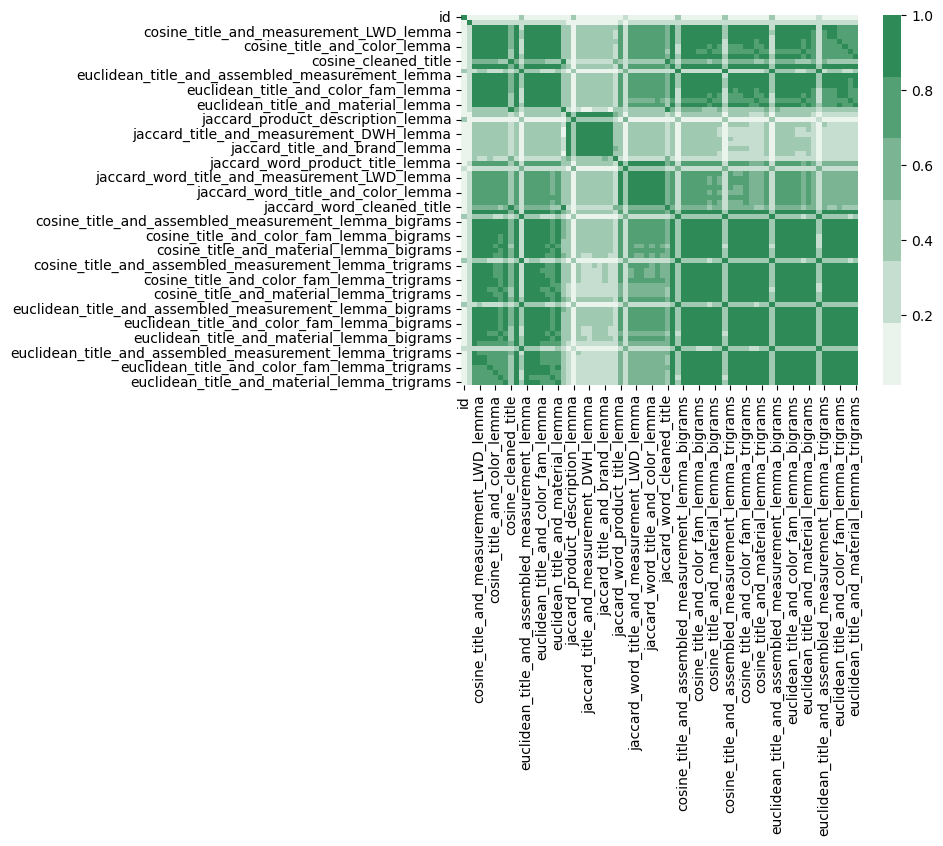

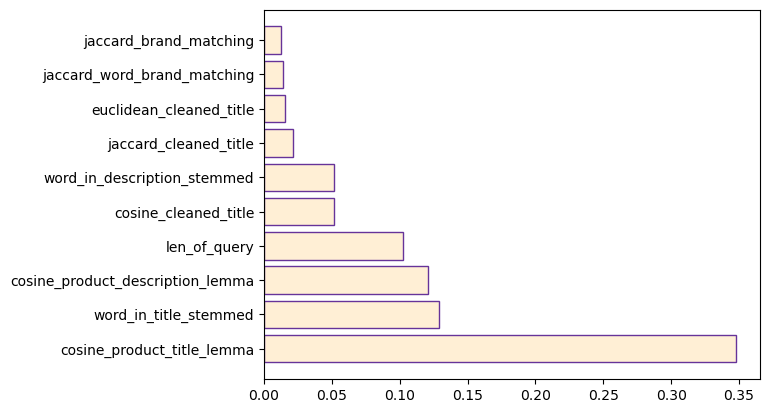

RMSE:  0.4953898084652659


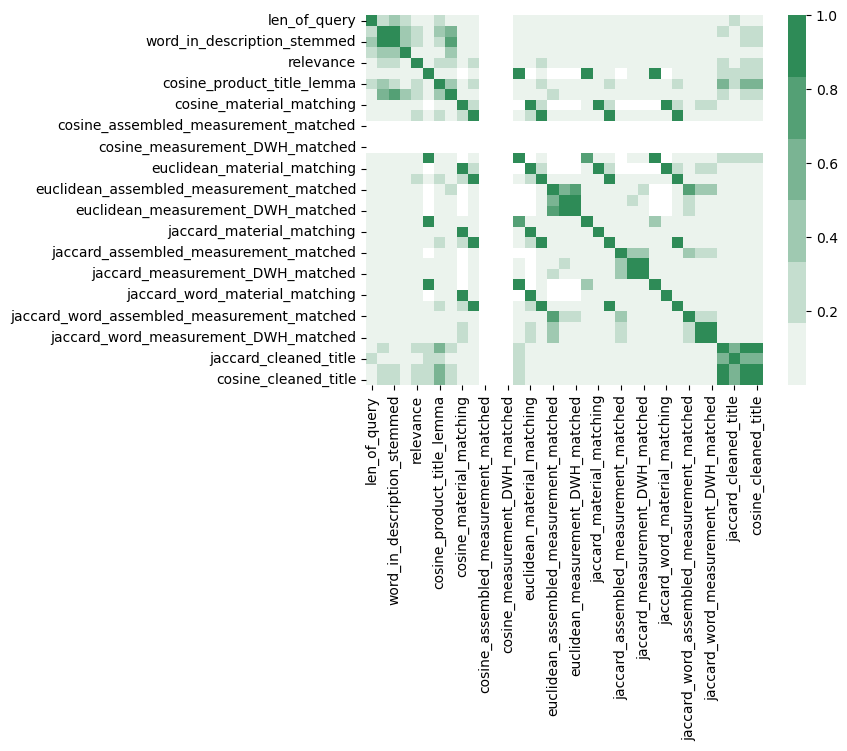

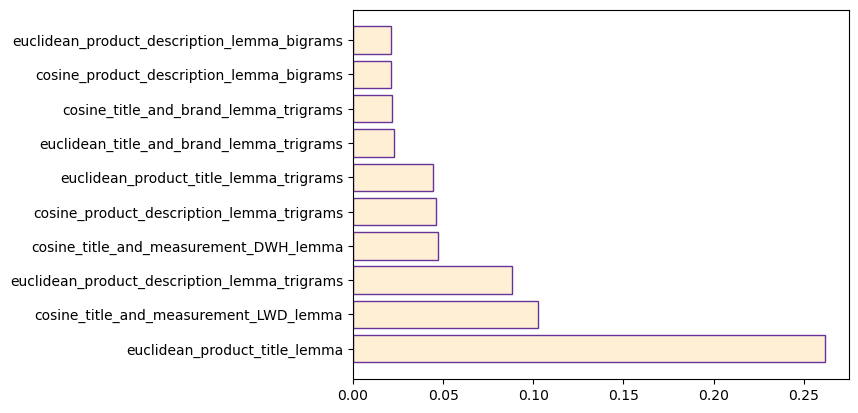

RMSE:  0.4852351674636351


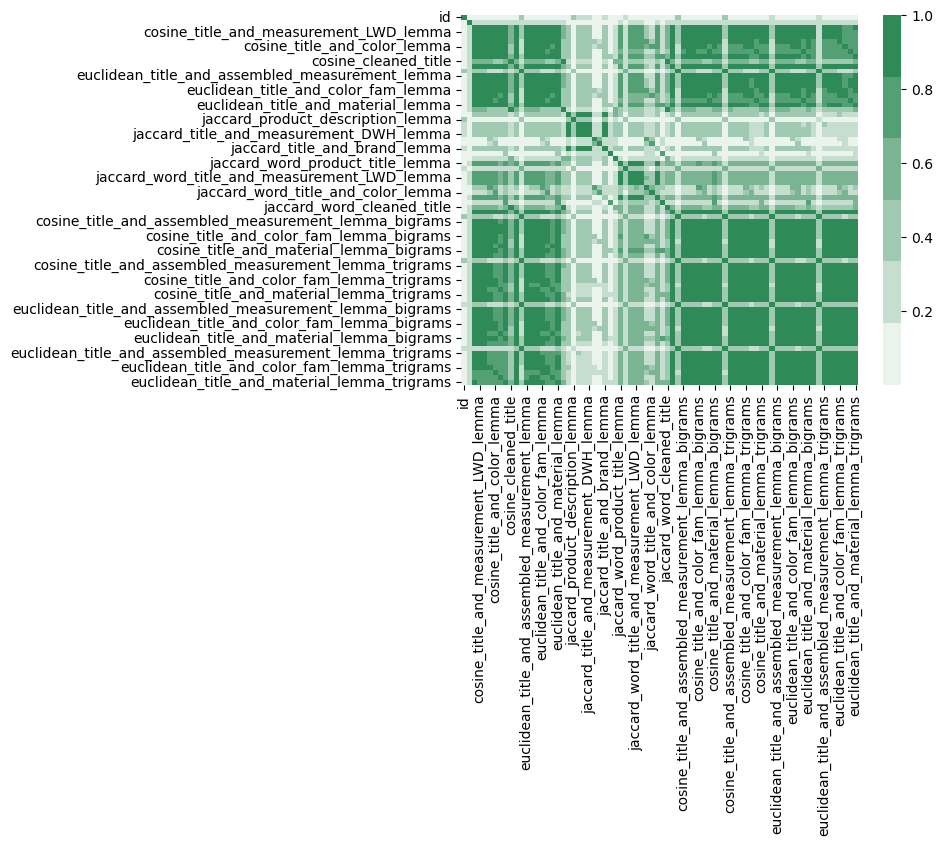

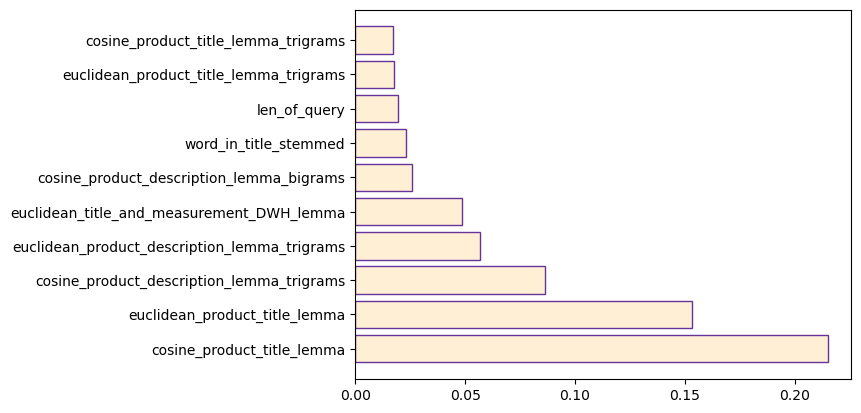

RMSE:  0.48540330122940933


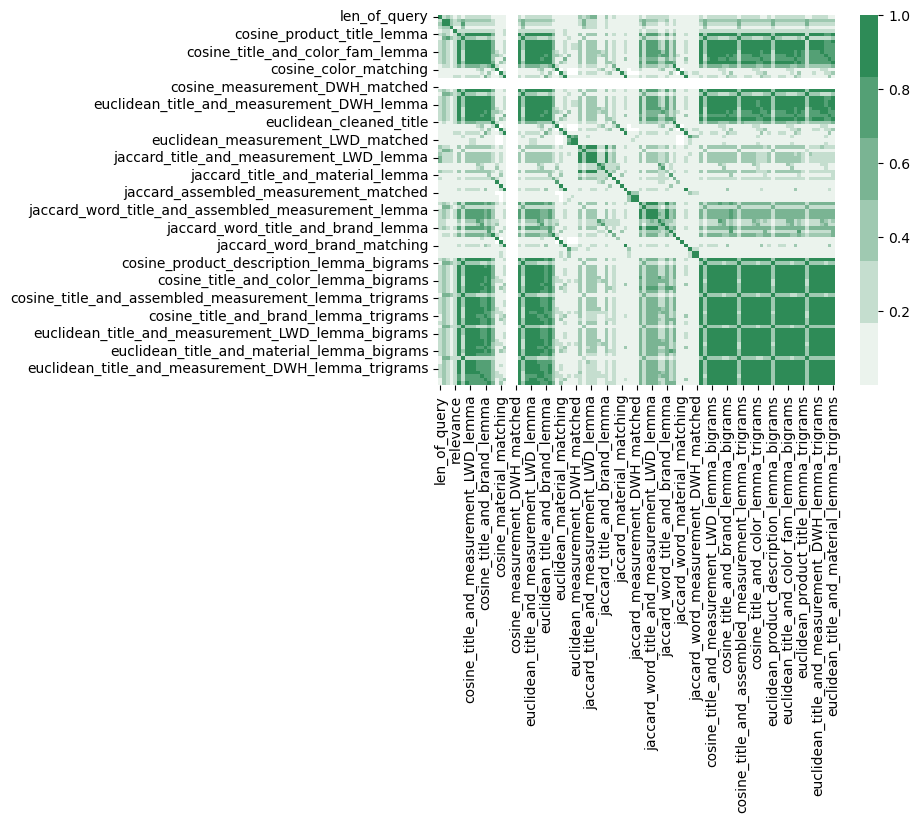

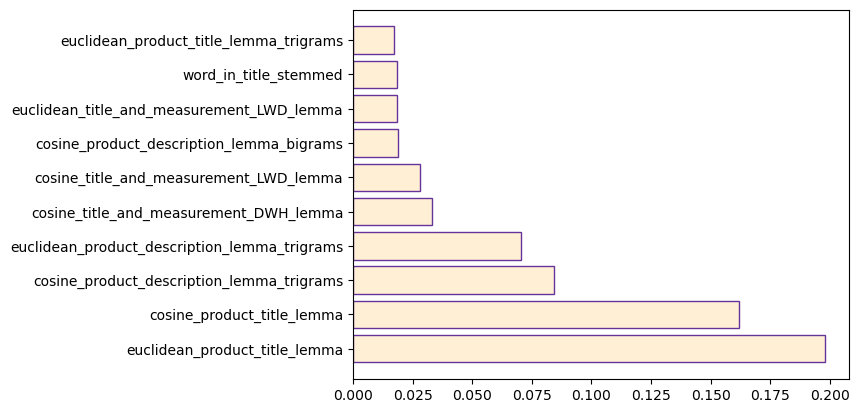

RMSE:  0.45750106883320557


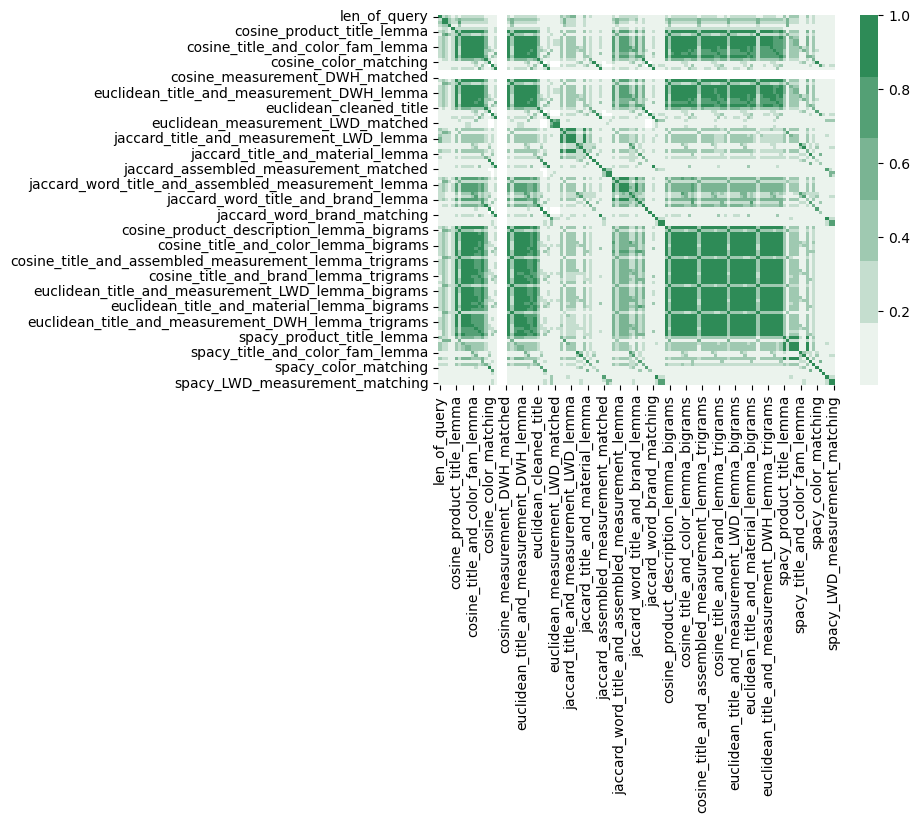

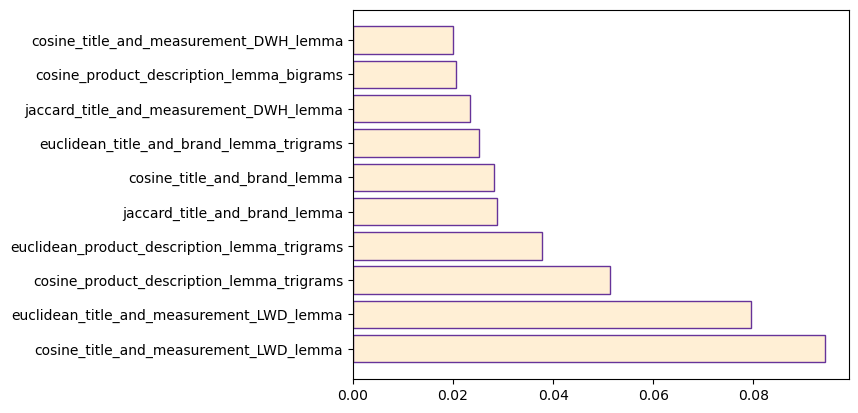

In [751]:
## CODE BLOCK 34: UNOPTIMISED REGRESSIONS -- COMPARE COUNT ONLY FEATURES IN WENXUAN CHEN CODE VS NEW COMPUTED FEATURES FOR FINAL ASSIGNMENT IN VARIOUS SEGMENTS

from xgboost import XGBRFRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns



def original_regression(feature_set, standardisation, return_regression = False):
  # Extract feature labels
  feature_weight_labels = list(feature_set.columns)
  feature_weight_labels.remove('id')
  feature_weight_labels.remove('relevance')

  # Handle datasets
  y = feature_set['relevance'].values
  X = feature_set.drop(['id', 'relevance'], axis = 1).values

  # Standardise features
  if standardisation == True:
    standardiser = StandardScaler()
    standardiser.fit(X)
    X = standardiser.transform(X)

  # Make train-validation sets from the training set
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 25)

  xgboost = XGBRFRegressor(random_state = 25, n_estimators = 45)
  rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=25)
  br = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
  rf.fit(X_train, y_train)
  br.fit(X_train, y_train)
  xgboost.fit(X_train, y_train)
  y_pred_rf = rf.predict(X_test)
  y_pred_xg = xgboost.predict(X_test)
  y_pred_br = br.predict(X_test)
  rmse_rf = mean_squared_error(y_test, y_pred_rf, squared = False)
  rmse_xg = mean_squared_error(y_test, y_pred_xg, squared = False)
  rmse_br = mean_squared_error(y_test, y_pred_br, squared = False)

  if return_regression == True:
    return rmse_rf, rmse_br, rmse_xg, rf, br, xgboost
  else:
    return rmse_rf, rmse_br, rmse_xg





def xgboost_new(feature_set):
  # Extract feature labels
  feature_weight_labels = list(feature_set.columns)
  feature_weight_labels.remove('id')
  feature_weight_labels.remove('relevance')

  # Split training and validation = 'test' set
  y = feature_set['relevance'].values
  X = feature_set.drop(['id','relevance'],axis=1).values


  # Standardise Features
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 25)

  # Train and fit the model
  xgboost = XGBRFRegressor(random_state = 25)
  xgboost.fit(X_train, y_train)
  y_pred_xg = xgboost.predict(X_test)

  # Calculate Root Mean Squared Error
  rmse_xg = mean_squared_error(y_test, y_pred_xg, squared = False)
  print("RMSE: ", rmse_xg)  

  # Extract tree-based (Gini) importance
  feature_weights = list(xgboost.feature_importances_)

  # Form mapping of label - feature via dictionary for Gini importance
  features_with_labels = dict()
  for key, value in zip(feature_weight_labels, feature_weights):
    features_with_labels[value] = key
  
  # Sort Gini importance features
  feature_weights = list(features_with_labels.keys())
  sorted_feature_weights = sorted(feature_weights, reverse = True)
  
  # Map back labels to features
  sorted_features_with_labels = dict()
  for feature_score in sorted_feature_weights:
    sorted_features_with_labels[features_with_labels[feature_score]] = feature_score
  
  feature_labels = list(sorted_features_with_labels.keys())[:10]
  feature_scores = list(sorted_features_with_labels.values())[:10]

  # Plot Gini feature importance
  fig, ax = plt.subplots()
  ax.barh(range(len(feature_scores)), feature_scores, color = "papayawhip", edgecolor = "rebeccapurple")
  ax.set_yticks(range(len(feature_scores)), labels = feature_labels)
  plt.show()

  # Plot correlation heatmap of features
  correlations = feature_set.corr().abs()
  # upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(bool))
  # to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
  # correlations.drop(to_drop, axis = 1, inplace = True)
  # correlations.drop(to_drop, axis = 0, inplace = True)
  sns.heatmap(correlations, cmap = sns.light_palette("seagreen"))

  return rmse_xg





random_forest, bagging_regressor, xgboost = original_regression(non_nan_features, standardisation = False)
random_forest_with_standard, bagging_regressor_with_standard, xgboost_with_standard = original_regression(non_nan_features, standardisation = True)

random_forest_old_features, bagging_regressor_old_features, xgboost_old_features = original_regression(original_features, standardisation = False)
random_forest_old_features_standard, bagging_regressor_old_features_standard, xgboost_old_features_standard = original_regression(original_features, standardisation = True)

random_forest_composite_features_rmse, bagging_regressor_composite_features_rmse, xgboost_composite_features_rmse, random_forest_composite_features_default, bagging_regressor_composite_features_default,xgboost_composite_features_default = original_regression(non_nan_composite_features, standardisation = True, return_regression = True)
random_forest_matching_features, bagging_regressor_matching_features, xgboost_matching_features = original_regression(non_nan_matching_features, standardisation = True)

random_forest_new_features_with_spacy, bagging_regressor_new_features_with_spacy, xgboost_new_features_with_spacy = original_regression(non_nan_new_features_with_spacy, standardisation = True)

# random_forest_old_features_new_preprocessing, bagging_regressor_old_features_new_preprocessing, xgboost_old_features_new_preprocessing = original_regression(original_features_new_preprocessing, standardisation = False)
xgboost_new_features_only_matching = xgboost_new(new_features_only_matching)
xgboost_new_features_not_matching = xgboost_new(new_features_non_matching)
xgboost_new_features = xgboost_new(new_features)
xgboost_new_features_inc_spacy = xgboost_new(new_features_with_spacy)
xgboost_non_nan_composites = xgboost_new(non_nan_composite_features)





In [611]:
# CODE BLOCK 35: PRINT RESULTS OF UN-OPTIMISED MODELS
print("Random forest new features (non NaN): ", random_forest)
print("Bagging regressor new features (non NaN): ", bagging_regressor)
print("XG-Boost new features (non NaN): ", xgboost)
print("_____________________________________________________________________________")
print("Random forest new features (non-nan), with standardisation (non NaN): ", random_forest_with_standard)
print("Bagging regressor new features (non-nan), with standardisation (non NaN): ", bagging_regressor_with_standard)
print("XG-Boost new features (non-nan), with standardisation (non NaN): ", xgboost_with_standard)
print("_____________________________________________________________________________")
print("Random forest old features (non NaN): ", random_forest_old_features)
print("Bagging regressor old features (non NaN): ", bagging_regressor_old_features)
print("XG-Boost old features (non NaN): ", xgboost_old_features)
print("______________________________________________________________________________")
print("Random forest old features, with standardisation (non NaN): ", random_forest_old_features_standard)
print("Bagging regressor old features, with standardisation (non NaN): ", bagging_regressor_old_features_standard)
print("XG-Boost old features, with standardisation(non NaN): ", xgboost_old_features_standard)
print("______________________________________________________________________________")
print("Random forest new composite features, with standardisation (non NaN): ", random_forest_composite_features_rmse)
print("Bagging regressor new composite features, with standardisation (non NaN): ", bagging_regressor_composite_features_rmse)
print("XG-Boost new composite features, with standardisation (non NaN): ", xgboost_composite_features_rmse)
print("______________________________________________________________________________")
print("Random forest new matching features, with standardisation (non NaN): ", random_forest_matching_features)
print("Bagging regressor new matching features, with standardisation (non NaN): ", bagging_regressor_matching_features)
print("XG-Boost new matching features, with standardisation (non NaN): ", xgboost_matching_features)
print("______________________________________________________________________________")
print("Random forest new features inc. spacy, with standardisation (non NaN): ", random_forest_new_features_with_spacy)
print("Bagging regressor new features inc. spacy, with standardisation (non NaN): ", bagging_regressor_new_features_with_spacy)
print("XG-Boost new features inc. spacy, with standardisation (non NaN): ", xgboost_new_features_with_spacy)
print("______________________________________________________________________________")
print("XG-Boost new features, only matching (with NaN): ", xgboost_new_features_only_matching)
print("______________________________________________________________________________")
print("XG-Boost new features, no matching (with NaN): ", xgboost_new_features_not_matching)
print("______________________________________________________________________________")
print("XG-Boost new features (with NaN): ", xgboost_new_features)
print("______________________________________________________________________________")
print("XG-Boost new features including spacy (with NaN): ", xgboost_new_features_inc_spacy)
print("______________________________________________________________________________")



Random forest new features (non-nan):  0.48490060843845334
Bagging regressor new features (non-nan):  0.48818297735125704
XG-Boost new features (non-nan):  0.48526697001103725
_____________________________________________________________________________
Random forest new features (non-nan), with standardisation:  0.4849112789159949
Bagging regressor new features (non-nan), with standardisation:  0.48817858926039437
XG-Boost new features (non-nan), with standardisation:  0.48526697001103725
_____________________________________________________________________________
Random forest old features:  0.495896031815335
Bagging regressor old features:  0.4953635564453467
XG-Boost old features:  0.4957902167409902
______________________________________________________________________________
Random forest old features, with standardisation:  0.495896031815335
Bagging regressor old features, with standardisation:  0.495368024213917
XG-Boost old features, with standardisation:  0.4957902167409902

In [624]:
# CODE BLOCK 36: GRID SEARCH OPTIMISATION FOR XGBOOST -- DUE TO TIME CONSTRAINTS DID NOT FOLLOW THIS FOR EVERY SEGMENT OF THE DATA

# Grid Search Optimisation for XGBoost

xg_boost_new_features = non_nan_composite_features


y = xg_boost_new_features['relevance'].values
X = xg_boost_new_features.drop(['id','relevance'],axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 25)


xgb = XGBRFRegressor(random_state = 25)

parameter_grid_xgb = {
    'max_depth':[0, 3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample':[0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'alpha': [0, 10, 20, 50, 100],
    'lambda': [0, 10, 20, 50, 100]
}


grid_search_xgboost = GridSearchCV(xgb, parameter_grid_xgb, scoring = 'neg_root_mean_squared_error', random_state = 25)
grid_search_xgboost.fit(X_train, y_train)
grid_search_xgboost.best_params_
rmse_xgb_train = grid_search_xgboost.score(X_train, y_train)
rmse_xgb_validation = grid_search_xgboost.score(X_test, y_test)

print(grid_search_xgboost.best_params_, rmse_xgb_train, rmse_xgb_validation)

{'alpha': 0, 'colsample_bytree': 0.7, 'lambda': 0, 'learning_rate': 0.2, 'max_depth': 0, 'subsample': 1} -0.41212603611780485


In [656]:
rmse_validation_xgboost_hyperopt = grid_search_xgboost.score(X_test, y_test)

y_pred_xg_hyperopt = grid_search_xgboost.predict(X_test)
rmse_xg_hyperopt = mean_squared_error(y_test, y_pred_xg_hyperopt, squared = False)

print("RMSE train: ", rmse_xgb_train)
print("RMSE validation: ", rmse_validation_xgboost_hyperopt)
print("Best cross-validation RMSE: ", grid_search_xgboost.best_score_)




RMSE train:  -0.41212603611780485
RMSE validation:  -0.4872323041876082
-0.4989606647731007


In [625]:
# CODE BLOCK 37: GRID SEARCH OPTIMISATION FOR RANDOM FOREST -- DUE TO TIME CONSTRAINTS DID NOT FOLLOW THIS FOR EVERY SEGMENT OF THE DATA

random_forest_composite_features = non_nan_composite_features

y = random_forest_composite_features['relevance'].values
X = random_forest_composite_features.drop(['id','relevance'],axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 25)


rf = RandomForestRegressor(random_state=25)

parameter_grid_rf = {
    'n_estimators': [25, 50, 100, 150, 200],
    'max_features': ['log2', 'sqrt', None],
    'max_depth': [3, 5, 7, 9],
    'max_leaf_nodes': [3, 5, 7, 9],
}



grid_search_rf = GridSearchCV(rf, parameter_grid_rf, scoring = 'neg_root_mean_squared_error')
grid_search_rf.fit(X_train, y_train)
grid_search_rf.best_params_
rmse_rf = grid_search_rf.score(X_train, y_train)

print(grid_search_rf.best_params_, rmse_rf)

{'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 200} -0.47650915367447166


In [655]:
rmse_rf_hyperopt_train = grid_search_rf.score(X_train, y_train)
rmse_rf_hyperopt_validation = grid_search_rf.score(X_test, y_test)

y_pred_rf_hyperopt = grid_search_rf.predict(X_test)
rmse_rf_hyperopt = mean_squared_error(y_test, y_pred_rf_hyperopt, squared = False)

print("RMSE train: ", rmse_rf_hyperopt_train)
print("RMSE validation: ",rmse_rf_hyperopt_validation)
print(grid_search_xgboost.best_score_)


RMSE train:  -0.47650915367447166
RMSE validation:  -0.4615434455973259
-0.4989606647731007


In [626]:
# CODE BLOCK 38: GRID SEARCH OPTIMISATION FOR BAGGING REGRESSOR -- DUE TO TIME CONSTRAINTS DID NOT FOLLOW THIS FOR EVERY SEGMENT OF THE DATA

bagging_regressor_composite_features = non_nan_composite_features

y = bagging_regressor_composite_features['relevance'].values
X = bagging_regressor_composite_features.drop(['id','relevance'],axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 25)


br = BaggingRegressor(grid_search_rf, random_state=25)


parameter_grid_br = {
    'max_samples': [0.05, 0.1, 0.2, 0.5],
}


grid_search_br = GridSearchCV(br, parameter_grid_br, scoring = 'neg_root_mean_squared_error')
grid_search_br.fit(X_train, y_train)
grid_search_br.best_params_
rmse_rf = grid_search_br.score(X_train, y_train)

print(grid_search_br.best_params_, rmse_rf)

KeyboardInterrupt: 

In [767]:
# CODE BLOCK 39: RANDOM SEARCH OPTIMISATION FOR XGBOOST (FUNCTION DEFINITION)

parameter_grid_xgb = {
    'max_depth':[0, 3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample':[0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'alpha': [0, 10, 20, 50, 100],
    'lambda': [0, 10, 20, 50, 100], 
    'gamma': [0.1, 0.5, 1]
}
def random_search(X_train, y_train, X_test, y_test):
  random_search_xgboost = RandomizedSearchCV(xgb, parameter_grid_xgb, scoring='neg_root_mean_squared_error', cv=15, random_state=25)
  random_search_xgboost.fit(X_train, y_train)
  rmse_rf_xgb_validation = random_search_xgboost.score(X_test, y_test)
  rmse_rf_xgb_train = random_search_xgboost.score(X_train, y_train)
  y_pred = random_search_xgboost.predict(X_test)
  print("best parameters: ", random_search_xgboost.best_params_, rmse_rf_xgb_validation, rmse_rf_xgb_train)
  print("Mean squared error on predictions: ", mean_squared_error(y_test, y_pred, squared = False))
  return random_search_xgboost.best_params_

# model = random_search(non_nan_features)

ONLY MATCHING WITHOUT CORRELATED FEATURES : 
best parameters:  {'subsample': 1, 'max_depth': 10, 'learning_rate': 0.2, 'lambda': 0, 'gamma': 1, 'colsample_bytree': 1, 'alpha': 50} -0.5277999948780415 -0.5252055980004751
Mean squared error on predictions:  0.5277999948780415
RMSE validation set:  0.5277999948780415


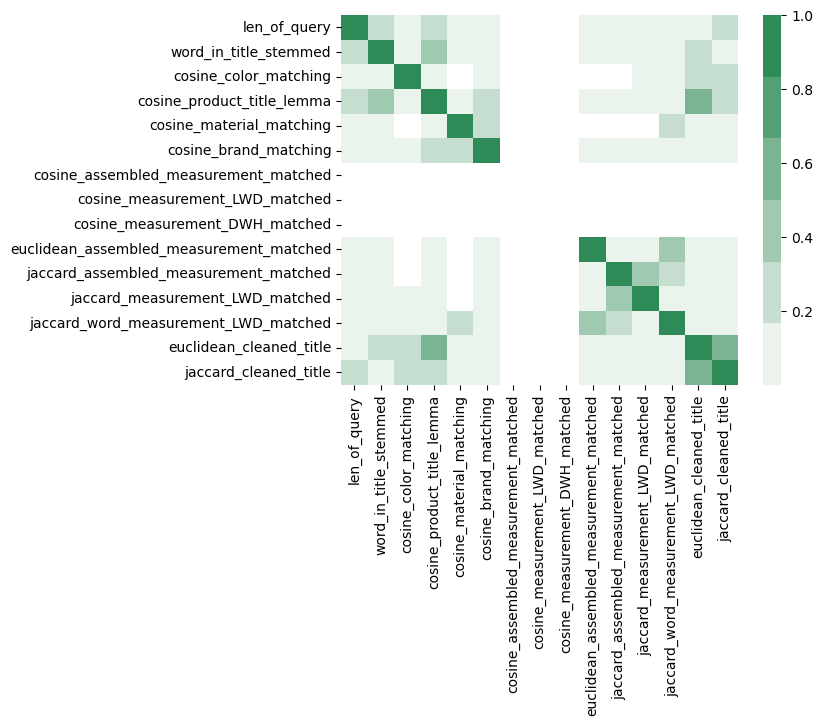

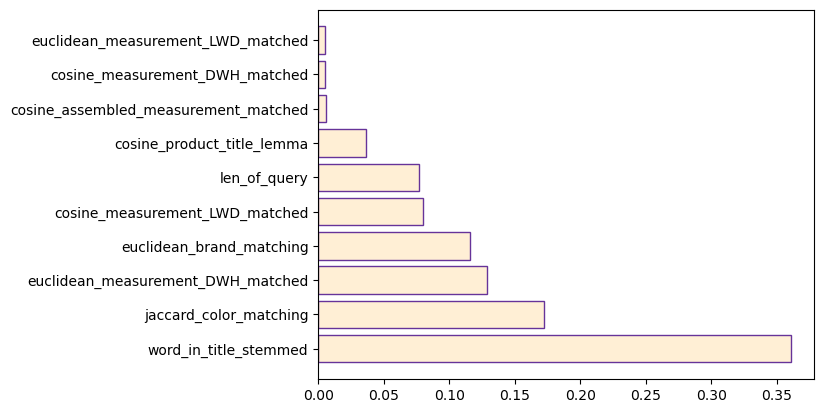

ONLY COMPOSITE WITHOUT CORRELATED FEATURES : 
best parameters:  {'subsample': 1, 'max_depth': 10, 'learning_rate': 0.2, 'lambda': 0, 'gamma': 1, 'colsample_bytree': 1, 'alpha': 50} -0.5244499742196544 -0.5214126330211178
Mean squared error on predictions:  0.5244499742196544
RMSE validation set:  0.5244499742196544


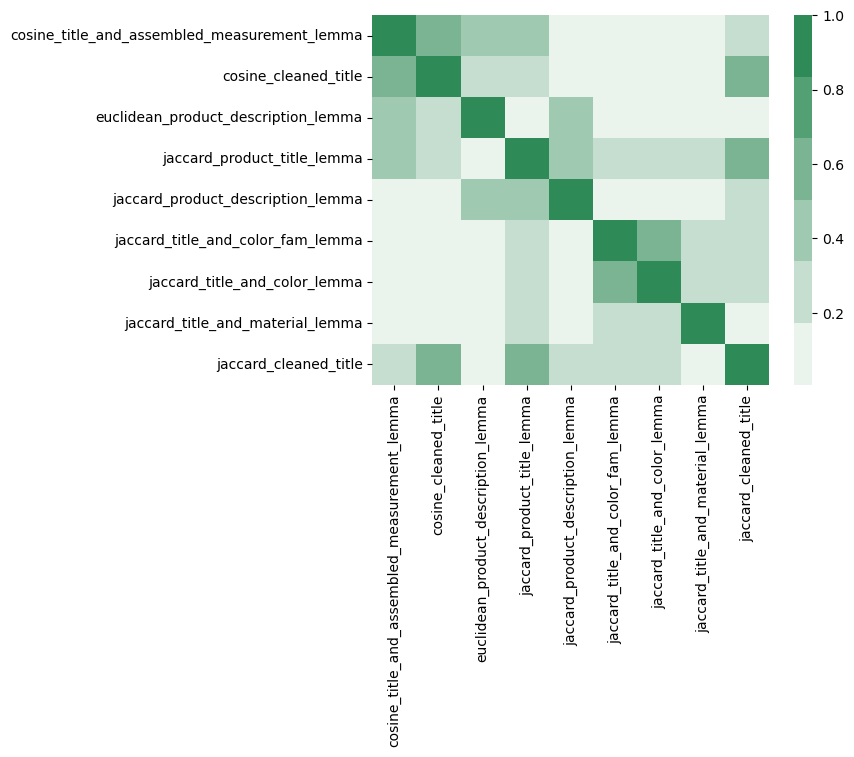

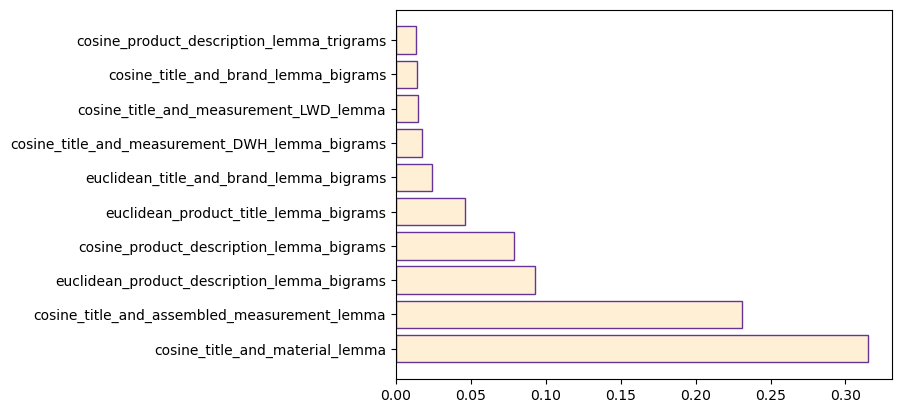

ALL FEATURES WITHOUT CORRELATED FEATURES : 
best parameters:  {'subsample': 1, 'max_depth': 10, 'learning_rate': 0.2, 'lambda': 0, 'gamma': 1, 'colsample_bytree': 1, 'alpha': 50} -0.5242694148927876 -0.521229956791318
Mean squared error on predictions:  0.5242694148927876
RMSE validation set:  0.5242694148927876


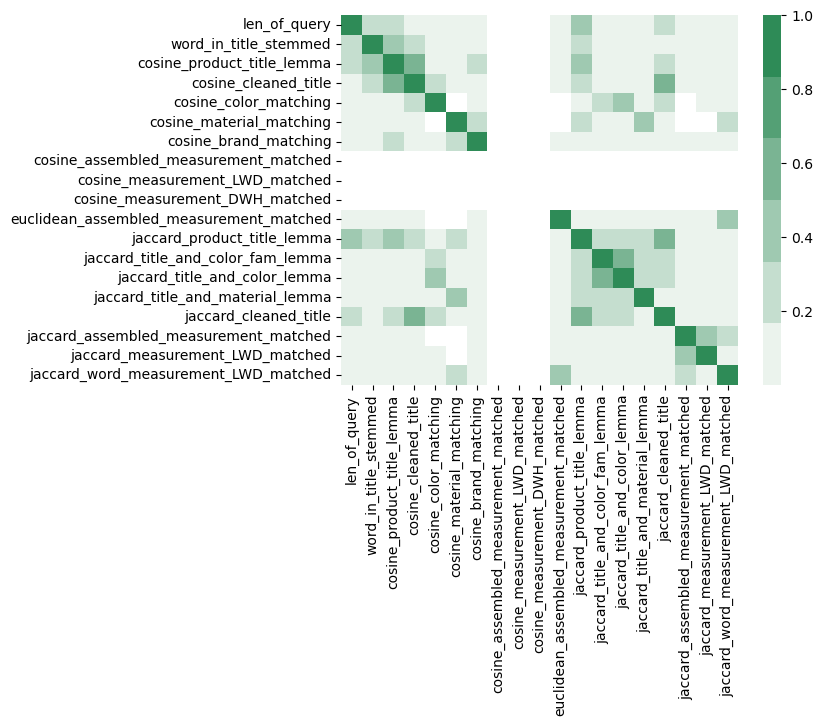

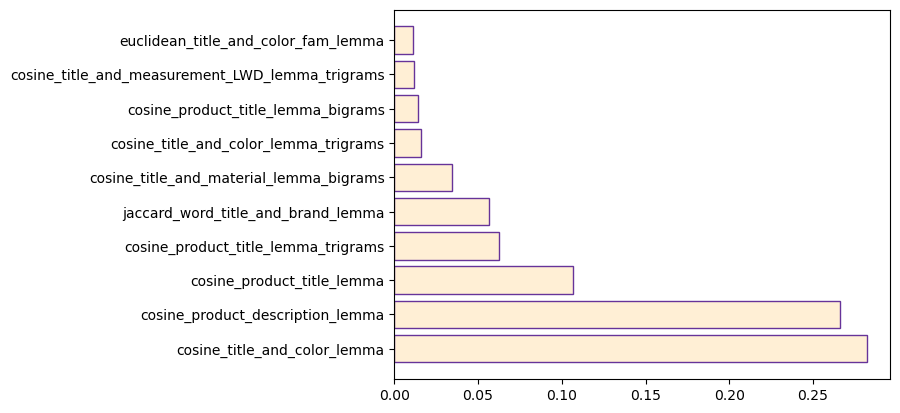

ALL FEATURES (NON-NAN) WITHOUT CORRELATED FEATURES : 
best parameters:  {'subsample': 1, 'max_depth': 10, 'learning_rate': 0.2, 'lambda': 0, 'gamma': 1, 'colsample_bytree': 1, 'alpha': 50} -0.5244966256659042 -0.521496153946029
Mean squared error on predictions:  0.5244966256659042
RMSE validation set:  0.5244966256659042


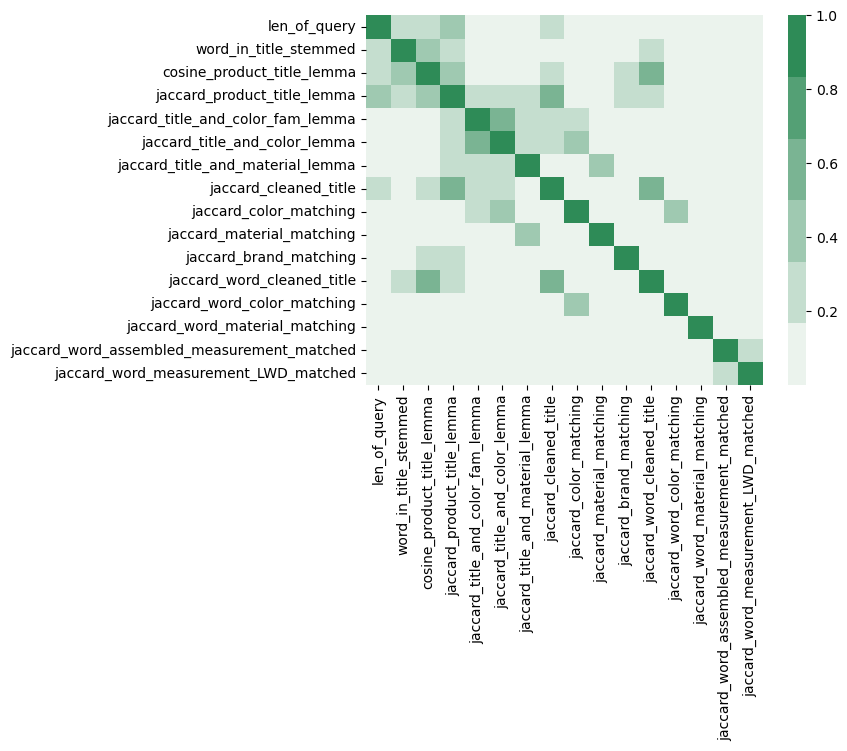

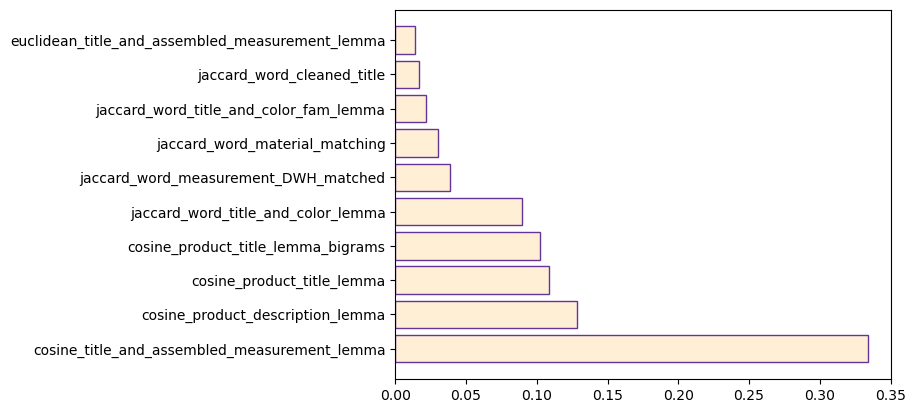

ALL FEATURES (inc. spacy) WITHOUT CORRELATED FEATURES : 
best parameters:  {'subsample': 1, 'max_depth': 10, 'learning_rate': 0.2, 'lambda': 0, 'gamma': 1, 'colsample_bytree': 1, 'alpha': 50} -0.5242437732104738 -0.5210751222032345
Mean squared error on predictions:  0.5242437732104738
RMSE validation set:  0.5242437732104738


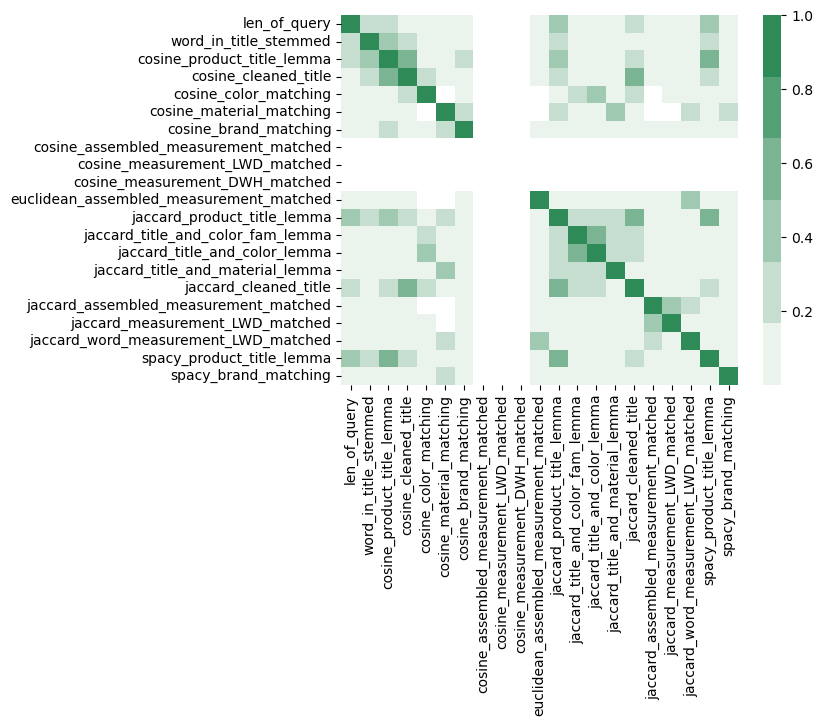

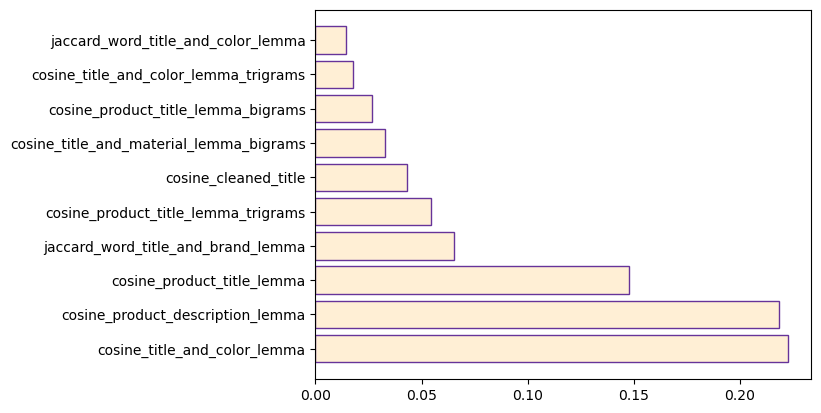

ONLY COMPOSITE (NON-NAN) WITHOUT CORRELATED FEATURES : 
best parameters:  {'subsample': 1, 'max_depth': 10, 'learning_rate': 0.2, 'lambda': 0, 'gamma': 1, 'colsample_bytree': 1, 'alpha': 50} -0.49638260945789586 -0.5056222322649868
Mean squared error on predictions:  0.49638260945789586
RMSE validation set:  0.49638260945789586


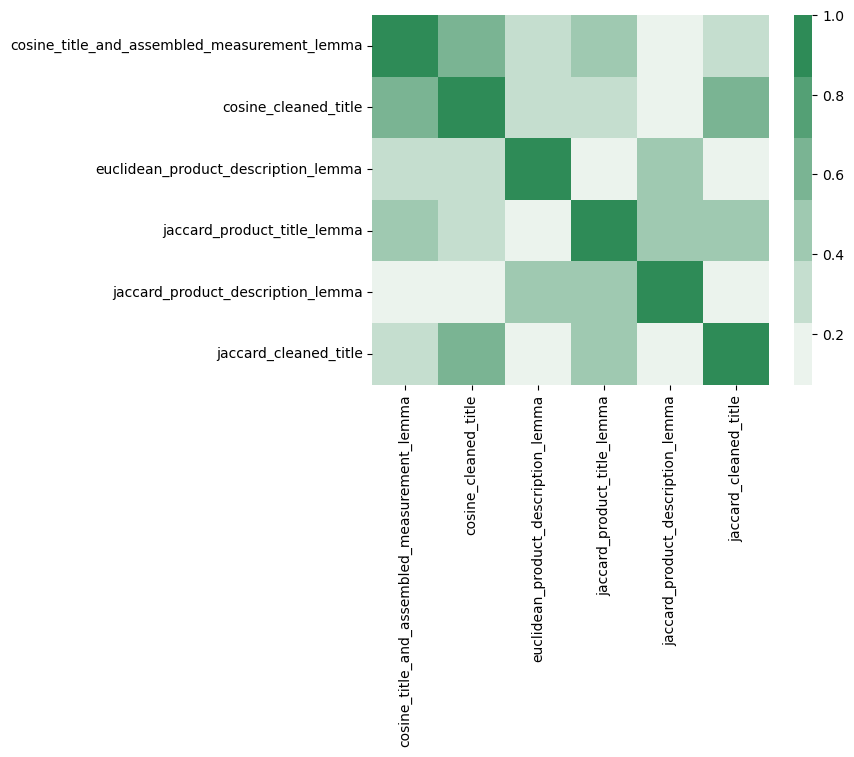

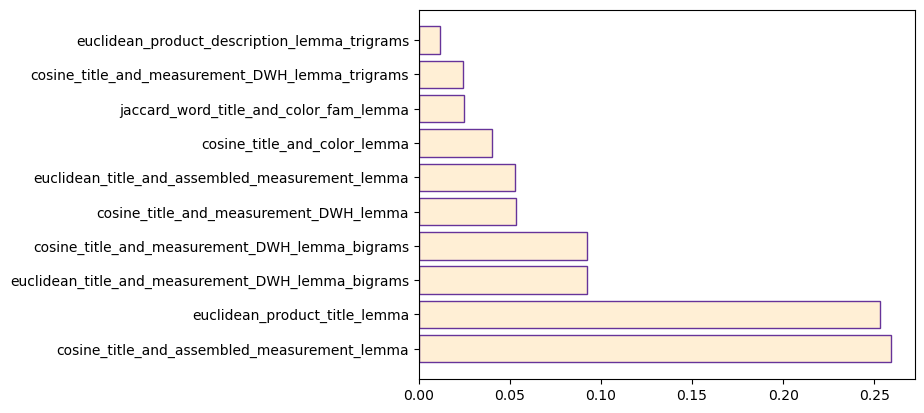

In [807]:
# CODE BLOCK 40: XG-BOOST WITHOUT HIGHLY CORRELATTED FEATURES, WITH RANDOM SEARCH HYPERPARAMETER OPTIMISATION


def xgboost_best_hyperparameters(feature_set, model_name: str):
  # Extract feature labels
  print(model_name, ": ")
  feature_weight_labels = list(feature_set.columns)
  feature_weight_labels.remove('id')
  feature_weight_labels.remove('relevance')

  y = feature_set['relevance'].values
  features_x = feature_set.drop(['id','relevance'],axis=1)
  X = features_x.values


  # Plot correlation heatmap of features
  correlations = features_x.corr().abs()
  upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(bool))
  # to_drop = [column for column in upper.columns if any(upper[column] < 0.2)]
  highly_correlated = [column for column in upper.columns if any(upper[column] > 0.60)]
  correlations.drop(highly_correlated, axis = 1, inplace = True)
  correlations.drop(highly_correlated, axis = 0, inplace = True)
  sns.heatmap(correlations, cmap = sns.light_palette("seagreen"))


  # Remove highly correlated features from model
  features_x = features_x.drop(correlations, axis = 1)
  X = features_x.values

  # Split training and validation = 'test' set
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 25)

  # Train and fit the model
  best_parameters = random_search(X_train, y_train, X_test, y_test)
  xgboost = XGBRFRegressor(random_state = 25, subsample = best_parameters['subsample'], max_depth = best_parameters['max_depth'], learning_rate = best_parameters['learning_rate'], reg_lambda = best_parameters['lambda'], gamma = best_parameters['gamma'], colsample_bytree = best_parameters['colsample_bytree'], alpha = best_parameters['alpha'])
  xgboost.fit(X_train, y_train)
  y_pred_xg = xgboost.predict(X_test)

  # Calculate Root Mean Squared Error
  rmse_xgb_train = xgboost.score(X_train, y_train)
  rmse_xg = mean_squared_error(y_test, y_pred_xg, squared = False)
  # print("RMSE train set: ", rmse_xgb_train)
  print("RMSE validation set: ", rmse_xg)
  
  # Extract tree-based (Gini) importance
  feature_weights = list(xgboost.feature_importances_)

  # Form mapping of label - feature via dictionary for Gini importance
  features_with_labels = dict()
  for key, value in zip(feature_weight_labels, feature_weights):
    features_with_labels[value] = key
  
  # Sort Gini importance features
  feature_weights = list(features_with_labels.keys())
  sorted_feature_weights = sorted(feature_weights, reverse = True)
  
  # Map back labels to features
  sorted_features_with_labels = dict()
  for feature_score in sorted_feature_weights:
    sorted_features_with_labels[features_with_labels[feature_score]] = feature_score
  
  feature_labels = list(sorted_features_with_labels.keys())[:10]
  feature_scores = list(sorted_features_with_labels.values())[:10]


  # Plot Gini feature importance
  fig, ax = plt.subplots()
  ax.barh(range(len(feature_scores)), feature_scores, color = "papayawhip", edgecolor = "rebeccapurple")
  ax.set_yticks(range(len(feature_scores)), labels = feature_labels)
  plt.show()


  return xgboost






# # Produce predictions to upload to Kaggle
xgboost_new_features_only_matching_2 = xgboost_best_hyperparameters(new_features_only_matching, model_name= "ONLY MATCHING WITHOUT CORRELATED FEATURES")
xgboost_new_features_not_matching_2 = xgboost_best_hyperparameters(new_features_non_matching, model_name = "ONLY COMPOSITE WITHOUT CORRELATED FEATURES")
xgboost_new_features_2 = xgboost_best_hyperparameters(new_features, model_name = "ALL FEATURES WITHOUT CORRELATED FEATURES")
xgboost_new_features_nonan_2 = xgboost_best_hyperparameters(non_nan_features, model_name = "ALL FEATURES (NON-NAN) WITHOUT CORRELATED FEATURES")

xgboost_new_features_inc_spacy_2 = xgboost_best_hyperparameters(new_features_with_spacy, model_name = "ALL FEATURES (inc. spacy) WITHOUT CORRELATED FEATURES")
xgboost_non_nan_composites_2 = xgboost_best_hyperparameters(non_nan_composite_features, model_name = "ONLY COMPOSITE (NON-NAN) WITHOUT CORRELATED FEATURES")



ONLY MATCHING WITHOUT CORRELATED FEATURES : 
Index(['word_in_description_stemmed', 'cosine_product_description_lemma',
       'euclidean_color_matching', 'euclidean_material_matching',
       'euclidean_brand_matching', 'euclidean_measurement_LWD_matched',
       'euclidean_measurement_DWH_matched', 'jaccard_color_matching',
       'jaccard_material_matching', 'jaccard_brand_matching',
       'jaccard_measurement_DWH_matched', 'jaccard_word_color_matching',
       'jaccard_word_material_matching', 'jaccard_word_brand_matching',
       'jaccard_word_assembled_measurement_matched',
       'jaccard_word_measurement_DWH_matched', 'jaccard_word_cleaned_title',
       'cosine_cleaned_title'],
      dtype='object')
RMSE validation set:  0.5113589678297893


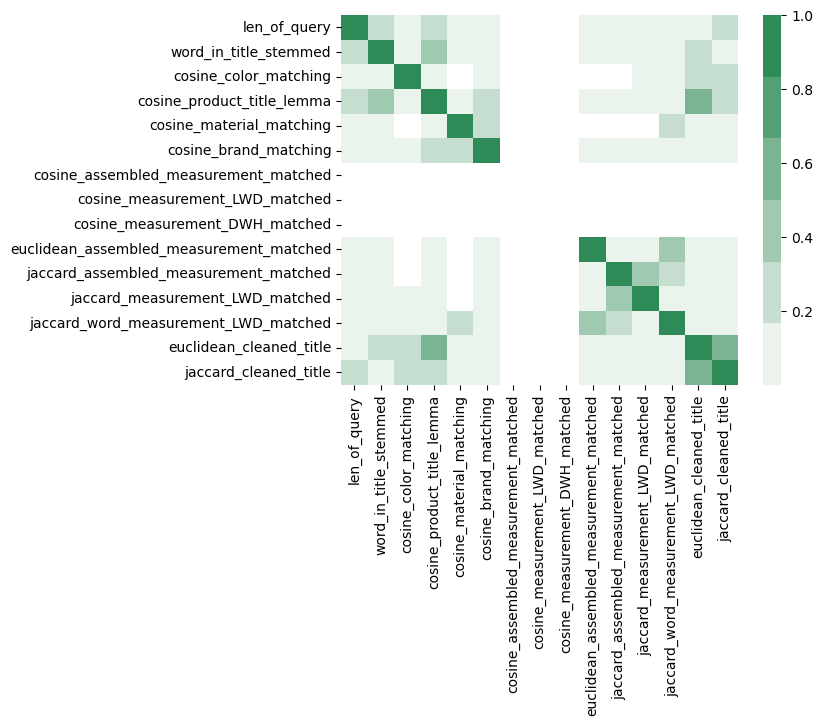

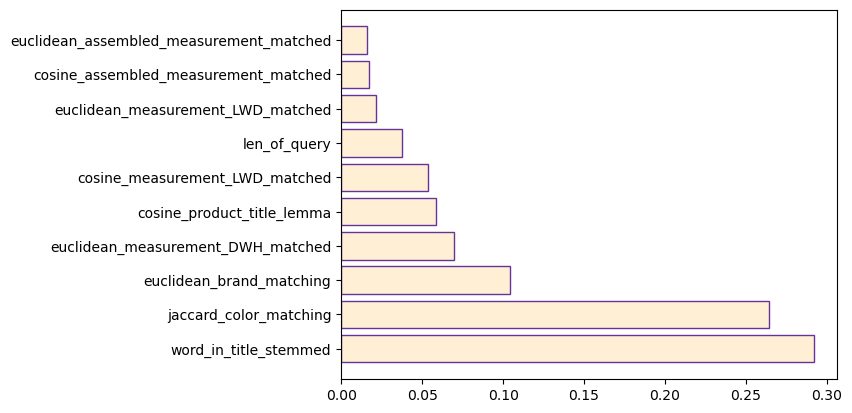

ONLY COMPOSITE WITHOUT CORRELATED FEATURES : 
Index(['cosine_title_and_measurement_LWD_lemma',
       'cosine_title_and_measurement_DWH_lemma',
       'cosine_title_and_color_fam_lemma', 'cosine_title_and_color_lemma',
       'cosine_title_and_brand_lemma', 'cosine_title_and_material_lemma',
       'euclidean_product_title_lemma',
       'euclidean_title_and_assembled_measurement_lemma',
       'euclidean_title_and_measurement_LWD_lemma',
       'euclidean_title_and_measurement_DWH_lemma',
       'euclidean_title_and_color_fam_lemma',
       'euclidean_title_and_color_lemma', 'euclidean_title_and_brand_lemma',
       'euclidean_title_and_material_lemma', 'euclidean_cleaned_title',
       'jaccard_title_and_assembled_measurement_lemma',
       'jaccard_title_and_measurement_LWD_lemma',
       'jaccard_title_and_measurement_DWH_lemma',
       'jaccard_title_and_brand_lemma', 'jaccard_word_product_title_lemma',
       'jaccard_word_product_description_lemma',
       'jaccard_word_title_an

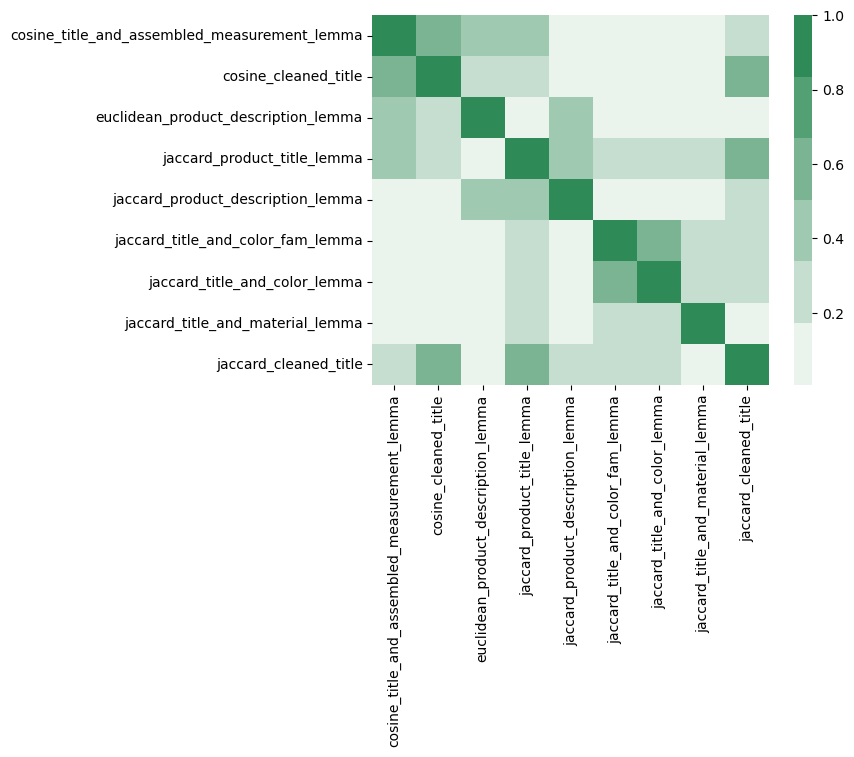

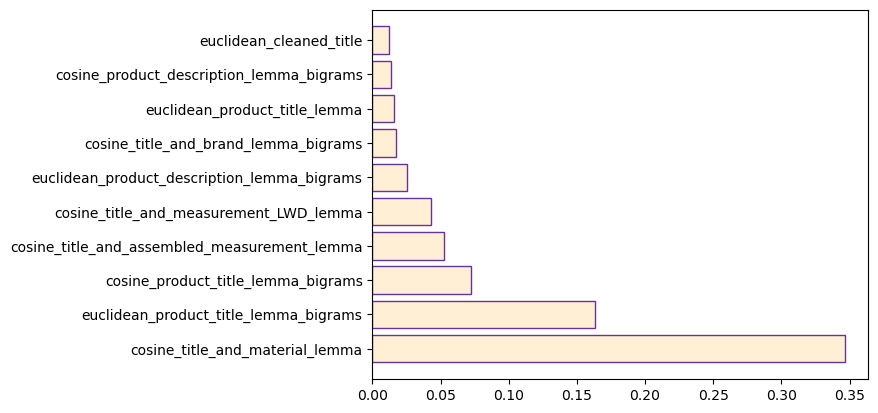

ALL FEATURES WITHOUT CORRELATED FEATURES : 
Index(['word_in_description_stemmed', 'cosine_product_description_lemma',
       'cosine_title_and_assembled_measurement_lemma',
       'cosine_title_and_measurement_LWD_lemma',
       'cosine_title_and_measurement_DWH_lemma',
       'cosine_title_and_color_fam_lemma', 'cosine_title_and_color_lemma',
       'cosine_title_and_brand_lemma', 'cosine_title_and_material_lemma',
       'euclidean_product_title_lemma', 'euclidean_product_description_lemma',
       'euclidean_title_and_assembled_measurement_lemma',
       'euclidean_title_and_measurement_LWD_lemma',
       'euclidean_title_and_measurement_DWH_lemma',
       'euclidean_title_and_color_fam_lemma',
       'euclidean_title_and_color_lemma', 'euclidean_title_and_brand_lemma',
       'euclidean_title_and_material_lemma', 'euclidean_cleaned_title',
       'euclidean_color_matching', 'euclidean_material_matching',
       'euclidean_brand_matching', 'euclidean_measurement_LWD_matched',
      

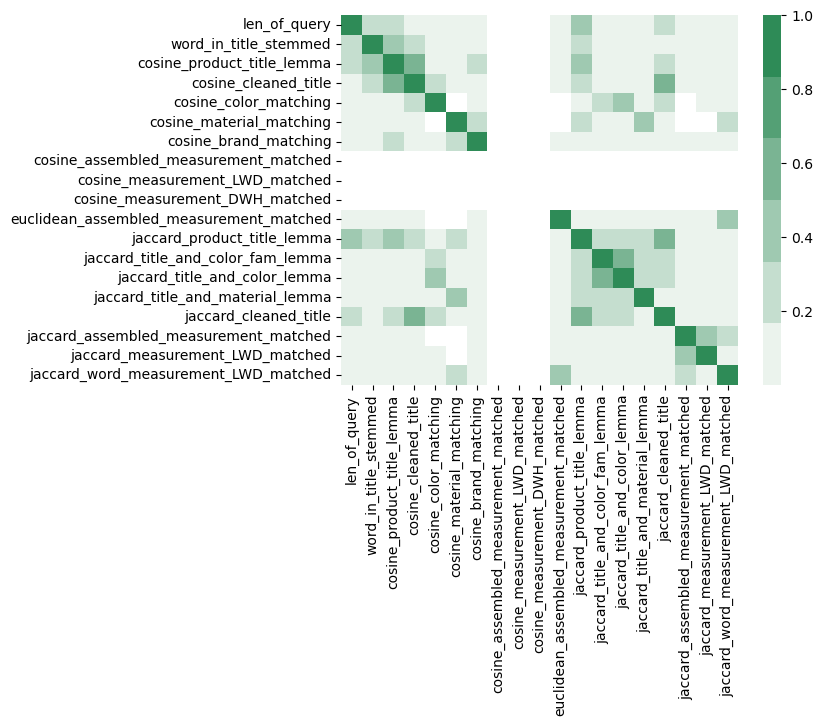

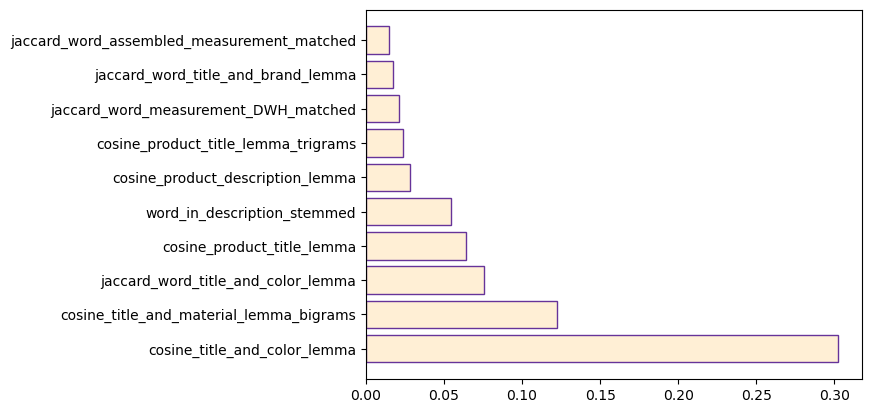

ALL FEATURES (NON-NAN) WITHOUT CORRELATED FEATURES : 
Index(['word_in_description_stemmed', 'cosine_product_description_lemma',
       'cosine_title_and_assembled_measurement_lemma',
       'cosine_title_and_measurement_LWD_lemma',
       'cosine_title_and_measurement_DWH_lemma',
       'euclidean_product_title_lemma', 'euclidean_product_description_lemma',
       'euclidean_title_and_assembled_measurement_lemma',
       'euclidean_title_and_measurement_LWD_lemma',
       'euclidean_title_and_measurement_DWH_lemma',
       'jaccard_product_description_lemma',
       'jaccard_title_and_assembled_measurement_lemma',
       'jaccard_title_and_measurement_LWD_lemma',
       'jaccard_title_and_measurement_DWH_lemma',
       'jaccard_title_and_brand_lemma', 'jaccard_word_product_title_lemma',
       'jaccard_word_product_description_lemma',
       'jaccard_word_title_and_assembled_measurement_lemma',
       'jaccard_word_title_and_measurement_LWD_lemma',
       'jaccard_word_title_and_measur

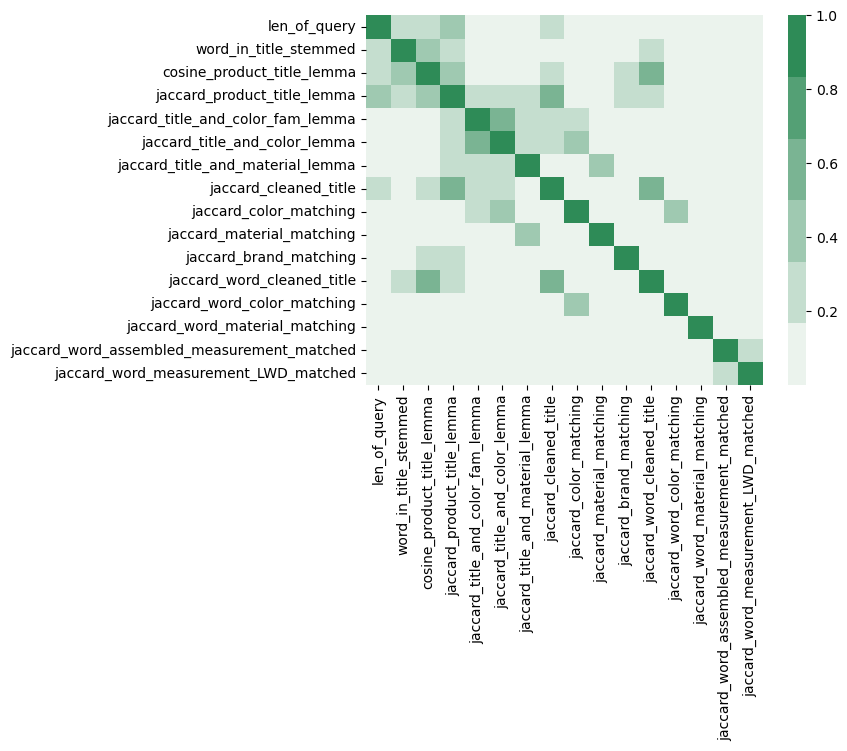

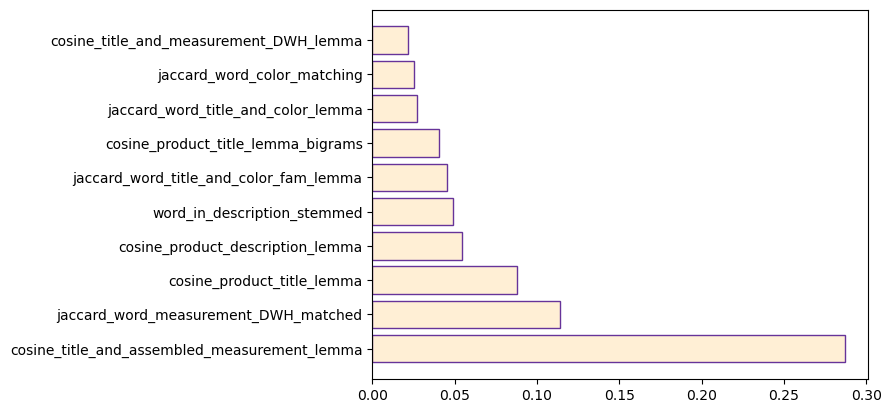

ALL FEATURES (inc. spacy) WITHOUT CORRELATED FEATURES : 
Index(['word_in_description_stemmed', 'cosine_product_description_lemma',
       'cosine_title_and_assembled_measurement_lemma',
       'cosine_title_and_measurement_LWD_lemma',
       'cosine_title_and_measurement_DWH_lemma',
       'cosine_title_and_color_fam_lemma', 'cosine_title_and_color_lemma',
       'cosine_title_and_brand_lemma', 'cosine_title_and_material_lemma',
       'euclidean_product_title_lemma', 'euclidean_product_description_lemma',
       'euclidean_title_and_assembled_measurement_lemma',
       'euclidean_title_and_measurement_LWD_lemma',
       'euclidean_title_and_measurement_DWH_lemma',
       'euclidean_title_and_color_fam_lemma',
       'euclidean_title_and_color_lemma', 'euclidean_title_and_brand_lemma',
       'euclidean_title_and_material_lemma', 'euclidean_cleaned_title',
       'euclidean_color_matching', 'euclidean_material_matching',
       'euclidean_brand_matching', 'euclidean_measurement_LWD_mat

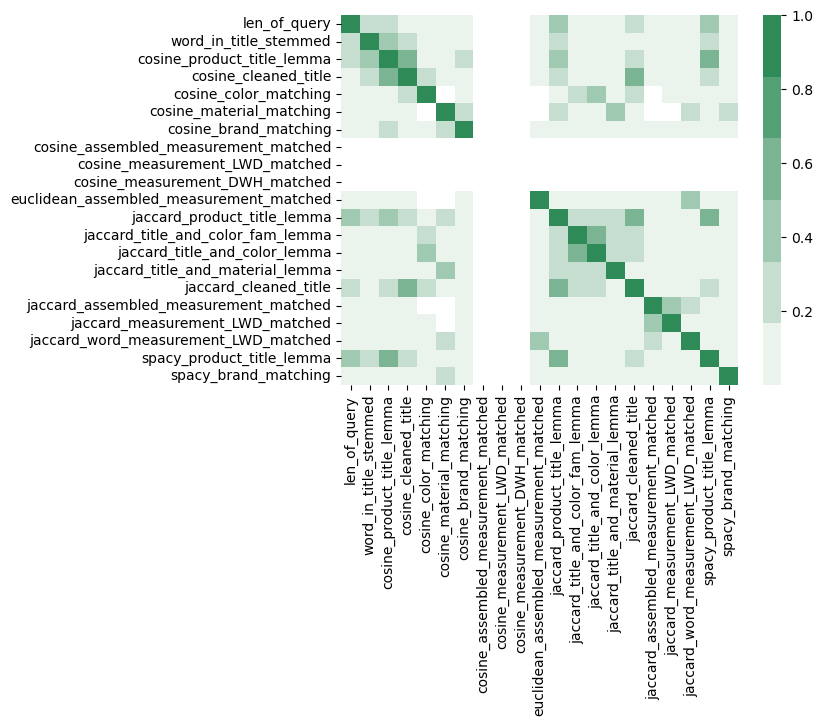

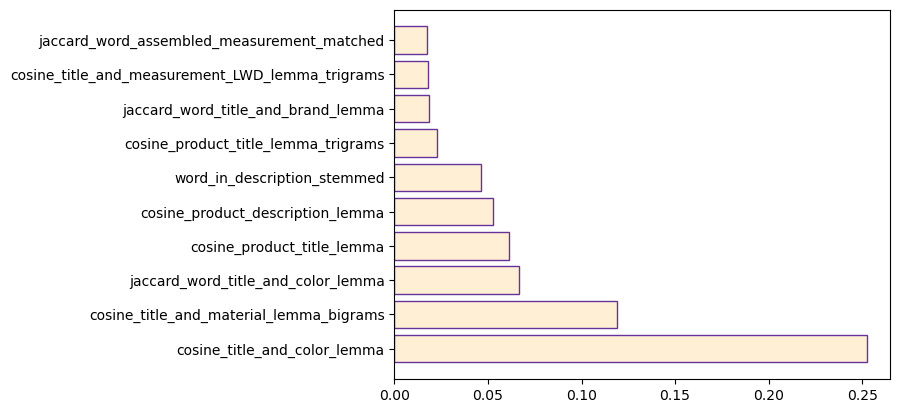

In [811]:
# CODE BLOCK 41: XG-BOOST WITHOUT HIGHLY CORRELATTED FEATURES, WITHOUT RANDOM SEARCH HYPERPARAMETER OPTIMISATION

def improved_xgboost_no_hyperparameters(feature_set, model_name: str, return_classifications = False):
  # Extract feature labels
  print(model_name, ": ")
  feature_weight_labels = list(feature_set.columns)
  feature_weight_labels.remove('id')
  feature_weight_labels.remove('relevance')

  # Split into train and test sets while keeping id's intact
  train_index = int(feature_set.shape[0] * 0.8)
  train_set = feature_set[:train_index]
  validation_set = feature_set[train_index:]
  validation_ids = validation_set['id']

  features_x = feature_set.drop(['id','relevance'],axis=1)
  

#   y = feature_set['relevance'].values
#   features_x = feature_set.drop(['id','relevance'],axis=1)
#   X = features_x.values


  # Plot correlation heatmap of features
  correlations = features_x.corr().abs()
  upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(bool))
  highly_correlated = [column for column in upper.columns if any(upper[column] > 0.60)]
  correlations.drop(highly_correlated, axis = 1, inplace = True)
  correlations.drop(highly_correlated, axis = 0, inplace = True)
  sns.heatmap(correlations, cmap = sns.light_palette("seagreen"))


  # Remove highly correlated features from model
  features_x = features_x.drop(correlations, axis = 1)
  print(features_x.columns)

  # Make X_train - validation, y_train - validation in order to preserve ids
  X_train = train_set[features_x.columns]
  X_test = validation_set[features_x.columns]
#   X_train = train_set.drop(['id', 'relevance'], axis = 1).values
#   X_test = validation_set.drop(['id', 'relevance'], axis = 1).values

  y_train = train_set['relevance'].values
  y_test = validation_set['relevance'].values

#   X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 25)


  # Train and fit the model
  xgboost = XGBRFRegressor(random_state = 25)
  xgboost.fit(X_train, y_train)
  y_pred_xg = xgboost.predict(X_test)

  # Calculate Root Mean Squared Error
  rmse_xgb_train = xgboost.score(X_train, y_train)
  rmse_xg = mean_squared_error(y_test, y_pred_xg, squared = False)
  # print("RMSE train set: ", rmse_xgb_train)
  print("RMSE validation set: ", rmse_xg)
  
  # Extract tree-based (Gini) importance
  feature_weights = list(xgboost.feature_importances_)

  # Form mapping of label - feature via dictionary for Gini importance
  features_with_labels = dict()
  for key, value in zip(feature_weight_labels, feature_weights):
    features_with_labels[value] = key
  
  # Sort Gini importance features
  feature_weights = list(features_with_labels.keys())
  sorted_feature_weights = sorted(feature_weights, reverse = True)
  
  # Map back labels to features
  sorted_features_with_labels = dict()
  for feature_score in sorted_feature_weights:
    sorted_features_with_labels[features_with_labels[feature_score]] = feature_score
  
  feature_labels = list(sorted_features_with_labels.keys())[:10]
  feature_scores = list(sorted_features_with_labels.values())[:10]


  # Plot Gini feature importance
  fig, ax = plt.subplots()
  ax.barh(range(len(feature_scores)), feature_scores, color = "papayawhip", edgecolor = "rebeccapurple")
  ax.set_yticks(range(len(feature_scores)), labels = feature_labels)
  plt.show()
  if return_classifications == True:
    return xgboost, y_test, y_pred_xg, X_test, validation_ids
  else:
    return xgboost



xgboost_new_features_only_matching_no_correlated = improved_xgboost_no_hyperparameters(new_features_only_matching, model_name= "ONLY MATCHING WITHOUT CORRELATED FEATURES")
xgboost_new_features_not_matching_no_correlated = improved_xgboost_no_hyperparameters(new_features_non_matching, model_name = "ONLY COMPOSITE WITHOUT CORRELATED FEATURES")
xgboost_new_features_no_correlated = improved_xgboost_no_hyperparameters(new_features, model_name = "ALL FEATURES WITHOUT CORRELATED FEATURES")
xgboost_new_features_nonan_no_correlated = improved_xgboost_no_hyperparameters(non_nan_features, model_name = "ALL FEATURES (NON-NAN) WITHOUT CORRELATED FEATURES")
xgboost_new_features_inc_spacy_no_correlated = improved_xgboost_no_hyperparameters(new_features_with_spacy, model_name = "ALL FEATURES (inc. spacy) WITHOUT CORRELATED FEATURES")





ONLY COMPOSITE (NON-NAN) WITHOUT CORRELATED FEATURES : 
Index(['cosine_title_and_measurement_LWD_lemma',
       'cosine_title_and_measurement_DWH_lemma',
       'cosine_title_and_color_fam_lemma', 'cosine_title_and_color_lemma',
       'cosine_title_and_brand_lemma', 'cosine_title_and_material_lemma',
       'euclidean_product_title_lemma',
       'euclidean_title_and_assembled_measurement_lemma',
       'euclidean_title_and_measurement_LWD_lemma',
       'euclidean_title_and_measurement_DWH_lemma',
       'euclidean_title_and_color_fam_lemma',
       'euclidean_title_and_color_lemma', 'euclidean_title_and_brand_lemma',
       'euclidean_title_and_material_lemma', 'euclidean_cleaned_title',
       'jaccard_title_and_assembled_measurement_lemma',
       'jaccard_title_and_measurement_LWD_lemma',
       'jaccard_title_and_measurement_DWH_lemma',
       'jaccard_title_and_color_fam_lemma', 'jaccard_title_and_color_lemma',
       'jaccard_title_and_brand_lemma', 'jaccard_title_and_material

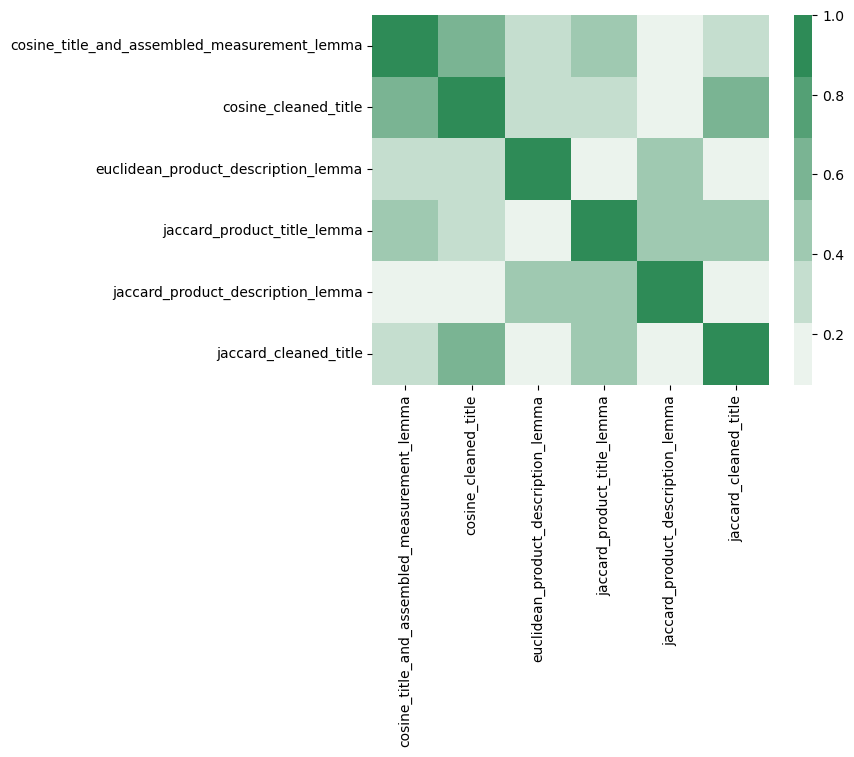

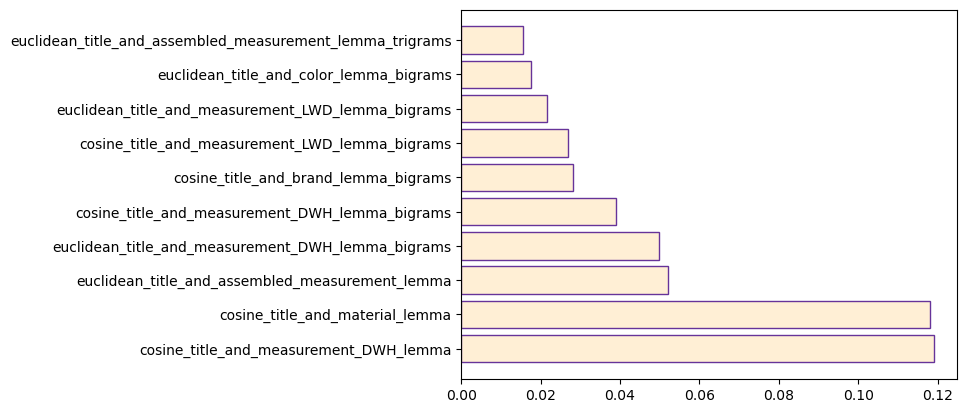

In [806]:
xgboost_non_nan_composites_no_correlated, y_test, y_pred, X_test, id_x = improved_xgboost_no_hyperparameters(non_nan_composite_features, model_name = "ONLY COMPOSITE (NON-NAN) WITHOUT CORRELATED FEATURES", return_classifications = True)


In [837]:
# CODE BLOCK 42: MISCLASSIFICATIONS

# print(len(id_x),len(y_test), len(y_pred))
ids = pd.DataFrame(id_x).reset_index()
test_relevances = pd.DataFrame(y_test)
pred_relevances = pd.DataFrame(y_pred)

classifications_test = pd.merge(ids, test_relevances, left_index = True, right_index = True)
classifications = pd.merge(classifications_test, pred_relevances, left_index = True, right_index = True)
classifications.columns = ["index", "proper_index", "actual_relevance", "predicted_relevance"]
classifications['difference'] = abs(classifications["actual_relevance"] - classifications["predicted_relevance"])
classifications.sort_values(by = 'difference', ascending = False)

index  proper_index  actual_relevance  predicted_relevance  difference
817   51012      204530.0              1.00             2.748104    1.748104
493   48882      198022.0              1.00             2.616960    1.616960
544   49162      198957.0              1.00             2.419510    1.419510
781   50705      203614.0              1.33             2.740358    1.410358
586   49465      199882.0              1.33             2.725955    1.395955
...     ...           ...               ...                  ...         ...
490   48858      197939.0              2.67             2.673033    0.003033
1535  56208      220400.0              2.33             2.327658    0.002342
1362  55053      216774.0              2.33             2.328005    0.001995
408   48246      196053.0              2.67             2.671463    0.001463
1006  52504      209052.0              2.33             2.330475    0.000475

[1595 rows x 5 columns]